In [1]:
%load_ext autoreload
%autoreload 2

import sys
import pickle 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

sys.path.append('../')

from src.training.caseci import *
from src.explainers import *
from src.timelimit import *
from src.explainers import *

pd.set_option('display.max_columns', 500)

import tensorflow as tf

## Get a model

In [2]:
case = CaseCI()

In [3]:
%%capture --no-display
case.train_model()

In [4]:
case.save_pipe(1, 'case_mean_imp')

 ROC AUC train :  0.6738824367934839 
 ROC AUC val :  0.6408452273092748 
 ROC AUC test :  0.6412330366802789 

Precision test :  0.8477747144545097
Recall test :  0.7040641099026903


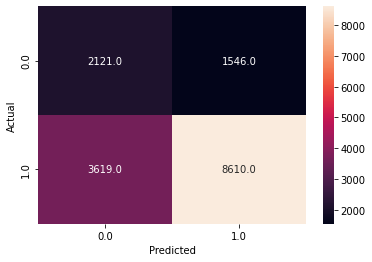

In [5]:
case.print_metrics()

## Changeable features

1.	Общее количество сделок, заключенных с организацией на текущий день. С ростом количества открытых сделок на одного клиента вероятность отказа снижается на 10%. Формулировка задачи: «Проверь по своим клиентам соблюдение контактной политики. Старайся оперативно реагировать на потребности клиента». Выводим, если менее 5 открытых сделок на одного клиента
F_5 (PDP-plot)
2.	Доля завершенных звонков среди всех активностей за 3 дня. С ростом доли звонков среди всех активностей вероятность отказа растет на 1%. «Старайся поддерживать очный контакт с клиентами». Выводим, если более 0.9 доля звонков.
F_12 (PDP-plot)
3.	Среднее количество уникальных продуктов, предложенных клиенту за 3 дня. С ростом количества уникальных предложенных продуктов вероятность отказа растет на 2%. «Старайся точно идентифицировать потребности клиента и не предлагать новые продукты без необходимости». Выводим, если более 4 количество уникальных предложенных продуктов.
F_24 (PDP-plot)
4.	Количество уникальных продуктов, предложенных клиентам за 3 дня. С ростом числа уникальных предложенных продуктов у клиента вероятность отказа растет на 0.9%. «Старайся не предлагать большой ряд продуктов, уточни потребность клиента». Выводим, если более 15 уникальных предложенных клиентам продуктов.
F_18 (PDP-plot)
5.	Среднее количество завершенных встреч и завершенных звонков за 3 дня. Если совершать встречи, вероятность отказа снижается на 0.4%. «Старайся поддерживать очный контакт с клиентом». Выводим, если нет встреч и есть звонки за последние 3 дня.
F_15, F_72 (PDP-plot)



## DiCE Report

### Generate counterfactuals for a sample n=100 using only changeable features

In [95]:
features_to_vary = ['F_5', 'F_12', 'F_24', 'F_18', 'F_15', 'F_72']

In [97]:
dice = DiCeReport(case, desired_class=0, 
                  features_to_vary=features_to_vary)
dice.create_explainer(method='random')

In [98]:
# example for one instance
dice.get_cf(7377, printout=True)

Generating cfs for 7377


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]

Query instance (original outcome : 1)


,F_0,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,F_10,F_11,F_12,F_13,F_14,F_15,F_16,F_17,F_18,F_19,F_20,F_21,F_22,F_23,F_24,F_25,F_26,F_27,F_28,F_29,F_30,F_31,F_32,F_33,F_34,F_35,F_36,F_37,F_38,F_39,F_40,F_41,F_42,F_43,F_44,F_45,F_46,F_47,F_48,F_49,F_50,F_51,F_52,F_53,F_54,F_55,F_56,F_57,F_58,F_59,F_60,F_61,F_62,F_63,F_64,F_65,F_66,F_67,F_68,F_69,F_70,F_71,F_72,F_73,F_74,F_75,F_76,F_77,F_78,F_79,F_80,F_81,F_82,F_83,F_84,target
0,0.0,1.0,0.20713,0.0,0.6,0.0,0.5,0.2,0.0,0.071429,0.0,0.526316,1.0,0.175993,6.693604e-17,0.0,0.0,0.482386,0.141361,0.12,0.236559,0.237246,0.292683,0.0,0.0,0.0,0.208508,1.0,0.2,0.121378,0.0,1.0,0.02,0.111111,0.0,0.0,0.098468,0.0,0.0,0.0,0.390244,0.321429,0.035433,0.008156,0.098039,0.299492,0.20234,0.055249,0.138887,0.064363,0.0,0.206897,0.0,0.758621,0.257426,0.0,0.72867,1.0,0.0,0.015991,0.0,0.0,0.257258,0.051282,0.0,0.15311,0.034483,1.0,0.148805,0.756045,0.0,0.049689,0.054096,0.198107,0.0,0.0,0.0,0.84689,0.0,0.008525,0.0,0.0,0.0,0.0,0.662129,1



Diverse Counterfactual set (new outcome: 0.0)


,F_0,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,F_10,F_11,F_12,F_13,F_14,F_15,F_16,F_17,F_18,F_19,F_20,F_21,F_22,F_23,F_24,F_25,F_26,F_27,F_28,F_29,F_30,F_31,F_32,F_33,F_34,F_35,F_36,F_37,F_38,F_39,F_40,F_41,F_42,F_43,F_44,F_45,F_46,F_47,F_48,F_49,F_50,F_51,F_52,F_53,F_54,F_55,F_56,F_57,F_58,F_59,F_60,F_61,F_62,F_63,F_64,F_65,F_66,F_67,F_68,F_69,F_70,F_71,F_72,F_73,F_74,F_75,F_76,F_77,F_78,F_79,F_80,F_81,F_82,F_83,F_84,target
0,-,-,-,-,-,-,-,-,-,-,-,-,0.6,-,-,-,-,-,0.15718538,-,-,-,-,-,-,-,-,-,-,-,-,-,1.02,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0344827582639713,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.0
1,-,-,-,-,-,-,-,-,-,-,-,-,0.3,-,-,-,-,-,-,-,-,-,-,-,0.1,-,-,-,-,-,-,-,1.02,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0344827582639713,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.0
2,-,-,-,-,-,-,-,-,-,-,-,-,0.7,-,-,0.1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.02,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0344827582639713,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.0
3,-,-,-,-,-,0.1,-,-,-,-,-,-,-,-,-,-,-,-,0.15181359,-,-,-,-,-,-,-,-,-,-,-,-,-,1.02,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0344827582639713,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.0
4,-,-,-,-,-,0.2,-,-,-,-,-,-,-,-,-,-,-,-,0.2125903,-,-,-,-,-,-,-,-,-,-,-,-,-,1.02,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0344827582639713,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.0


Stopped generating cfs for 7377


In [ ]:
# %%capture --no-display
dice.evaluate_dataset(n=1, save=True, name='case_dice_cf_all')

  0%|          | 0/10156 [00:00<?, ?it/s]

Generating cfs for 7806



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7806
Generating cfs for 4164



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4164
Generating cfs for 6902



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6902
Generating cfs for 10438



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 10438
Generating cfs for 11004



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11004
Generating cfs for 13505



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13505
Generating cfs for 6214



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 6214
Generating cfs for 10536



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10536
Generating cfs for 7653



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.10it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7653
Generating cfs for 5308



100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.36s/it]


Stopped generating cfs for 5308
 Found CF for 2 rows
Generating cfs for 10885



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10885
Generating cfs for 13810



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13810
Generating cfs for 9042



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 9042
Generating cfs for 397



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 397
Generating cfs for 9515



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9515
Generating cfs for 3844



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3844
Generating cfs for 7042



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7042
Generating cfs for 9508



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 9508
Generating cfs for 2483



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2483
Generating cfs for 7987



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7987
Generating cfs for 8379



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.25s/it]


Stopped generating cfs for 8379
 Found CF for 3 rows
Generating cfs for 14928



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14928
Generating cfs for 1211



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1211
Generating cfs for 12200



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12200
Generating cfs for 4044



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4044
Generating cfs for 8351



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8351
Generating cfs for 6219



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6219
Generating cfs for 15876



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15876
Generating cfs for 9921



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9921
Generating cfs for 10936



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10936
Generating cfs for 93



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 93
Generating cfs for 6696



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6696
Generating cfs for 11404



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11404
Generating cfs for 8473



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 8473
Generating cfs for 2729



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2729
Generating cfs for 7325



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7325
Generating cfs for 9940



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 9940
Generating cfs for 6546



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6546
Generating cfs for 6529



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6529
Generating cfs for 5609



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5609
Generating cfs for 15141



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15141
Generating cfs for 6558



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6558
Generating cfs for 5058



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.30s/it]


Stopped generating cfs for 5058
 Found CF for 4 rows
Generating cfs for 3179



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3179
Generating cfs for 8369



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8369
Generating cfs for 1290



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1290
Generating cfs for 2230



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 2230
Generating cfs for 6853



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6853
Generating cfs for 15066



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15066
Generating cfs for 3400



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3400
Generating cfs for 10369



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 10369
Generating cfs for 8508



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8508
Generating cfs for 3709



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 3709
Generating cfs for 10999



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10999
Generating cfs for 9028



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9028
Generating cfs for 15541



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15541
Generating cfs for 13039



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13039
Generating cfs for 14574



100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.13s/it]


Stopped generating cfs for 14574
 Found CF for 5 rows
Generating cfs for 12514



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 12514
Generating cfs for 11130



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11130
Generating cfs for 3048



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3048
Generating cfs for 11194



100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.42s/it]


Stopped generating cfs for 11194
 Found CF for 6 rows
Generating cfs for 10872



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10872
Generating cfs for 9568



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9568
Generating cfs for 3192



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3192
Generating cfs for 11816



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11816
Generating cfs for 14653



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14653
Generating cfs for 14097



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14097
Generating cfs for 12017



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12017
Generating cfs for 7033



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7033
Generating cfs for 5965



100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.50s/it]


Stopped generating cfs for 5965
 Found CF for 7 rows
Generating cfs for 11023



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11023
Generating cfs for 6151



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 6151
Generating cfs for 10186



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10186
Generating cfs for 1003



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1003
Generating cfs for 1724



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1724
Generating cfs for 6284



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6284
Generating cfs for 3



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3
Generating cfs for 9985



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9985
Generating cfs for 11749



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 11749
Generating cfs for 10810



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.16s/it]


Stopped generating cfs for 10810
 Found CF for 8 rows
Generating cfs for 12971



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 12971
Generating cfs for 3417



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.28s/it]


Stopped generating cfs for 3417
 Found CF for 9 rows
Generating cfs for 15309



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15309
Generating cfs for 12068



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12068
Generating cfs for 8953



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8953
Generating cfs for 6993



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.80s/it]


Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
Stopped generating cfs for 6993
 Found CF for 10 rows
Generating cfs for 11546



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 11546
Generating cfs for 12331



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 12331
Generating cfs for 5258



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5258
Generating cfs for 6098



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6098
Generating cfs for 152



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 152
Generating cfs for 5986



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5986
Generating cfs for 10729



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 10729
Generating cfs for 11720



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11720
Generating cfs for 3818



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3818
Generating cfs for 5644



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 5644
Generating cfs for 6565



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6565
Generating cfs for 9617



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 9617
Generating cfs for 8522



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8522
Generating cfs for 1679



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1679
Generating cfs for 11311



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11311
Generating cfs for 12043



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 12043
Generating cfs for 9091



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9091
Generating cfs for 1047



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1047
Generating cfs for 13182



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13182
Generating cfs for 651



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 651
Generating cfs for 5720



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5720
Generating cfs for 8762



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8762
Generating cfs for 1590



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1590
Generating cfs for 306



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 306
Generating cfs for 12712



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.88s/it]


Stopped generating cfs for 12712
 Found CF for 11 rows
Generating cfs for 7691



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 7691
Generating cfs for 9490



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9490
Generating cfs for 10969



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10969
Generating cfs for 8818



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 8818
Generating cfs for 1994



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1994
Generating cfs for 12801



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.27it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12801
Generating cfs for 7196



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 7196
Generating cfs for 15546



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15546
Generating cfs for 3819



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3819
Generating cfs for 9081



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9081
Generating cfs for 1436



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 1436
Generating cfs for 11494



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11494
Generating cfs for 14466



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14466
Generating cfs for 9783



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]


Stopped generating cfs for 9783
 Found CF for 12 rows
Generating cfs for 2618



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.65s/it]


Stopped generating cfs for 2618
 Found CF for 13 rows
Generating cfs for 5365



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5365
Generating cfs for 9445



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9445
Generating cfs for 6608



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6608
Generating cfs for 3157



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3157
Generating cfs for 185



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 185
Generating cfs for 7860



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 7860
Generating cfs for 5684



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5684
Generating cfs for 11200



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11200
Generating cfs for 2445



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2445
Generating cfs for 5794



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5794
Generating cfs for 6863



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6863
Generating cfs for 15011



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15011
Generating cfs for 12993



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12993
Generating cfs for 15190



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15190
Generating cfs for 8674



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 8674
Generating cfs for 5552



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5552
Generating cfs for 10934



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.18s/it]


Stopped generating cfs for 10934
 Found CF for 14 rows
Generating cfs for 11119



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11119
Generating cfs for 4586



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4586
Generating cfs for 3935



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3935
Generating cfs for 1526



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1526
Generating cfs for 1405



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 1405
Generating cfs for 1795



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1795
Generating cfs for 13228



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 13228
Generating cfs for 10490



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.33it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10490
Generating cfs for 4234



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.33it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4234
Generating cfs for 6804



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 6804
Generating cfs for 6874



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6874
Generating cfs for 8717



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8717
Generating cfs for 2420



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 2420
Generating cfs for 8398



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8398
Generating cfs for 9891



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 9891
Generating cfs for 15212



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15212
Generating cfs for 11369



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11369
Generating cfs for 7892



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7892
Generating cfs for 4453



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.58s/it]


Stopped generating cfs for 4453
 Found CF for 15 rows
Generating cfs for 6802



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6802
Generating cfs for 4503



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 4503
Generating cfs for 11162



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11162
Generating cfs for 6181



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6181
Generating cfs for 7449



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7449
Generating cfs for 15436



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.16s/it]


Stopped generating cfs for 15436
 Found CF for 16 rows
Generating cfs for 4974



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4974
Generating cfs for 2879



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2879
Generating cfs for 825



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 825
Generating cfs for 1323



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 1323
Generating cfs for 49



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 49
Generating cfs for 6613



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6613
Generating cfs for 6831



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6831
Generating cfs for 6970



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6970
Generating cfs for 14367



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14367
Generating cfs for 11789



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11789
Generating cfs for 3691



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3691
Generating cfs for 5044



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5044
Generating cfs for 5343



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.27it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5343
Generating cfs for 5727



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5727
Generating cfs for 15180



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15180
Generating cfs for 9142



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9142
Generating cfs for 11923



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11923
Generating cfs for 3090



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 3090
Generating cfs for 12684



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12684
Generating cfs for 9458



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9458
Generating cfs for 11000



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11000
Generating cfs for 2047



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2047
Generating cfs for 10550



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 10550
Generating cfs for 2309



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2309
Generating cfs for 12814



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12814
Generating cfs for 10185



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10185
Generating cfs for 14014



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14014
Generating cfs for 10492



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10492
Generating cfs for 4934



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4934
Generating cfs for 433



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 433
Generating cfs for 14770



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14770
Generating cfs for 11175



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11175
Generating cfs for 19



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 19
Generating cfs for 13671



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13671
Generating cfs for 4061



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4061
Generating cfs for 15362



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 15362
Generating cfs for 7040



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7040
Generating cfs for 3115



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 3115
Generating cfs for 7827



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7827
Generating cfs for 11700



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11700
Generating cfs for 1827



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1827
Generating cfs for 14322



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14322
Generating cfs for 5022



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5022
Generating cfs for 4217



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 4217
Generating cfs for 5875



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5875
Generating cfs for 7782



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7782
Generating cfs for 9310



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.47s/it]


Stopped generating cfs for 9310
 Found CF for 17 rows
Generating cfs for 2501



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 2501
Generating cfs for 14161



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14161
Generating cfs for 6864



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6864
Generating cfs for 10971



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.10it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10971
Generating cfs for 12398



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12398
Generating cfs for 10112



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10112
Generating cfs for 1410



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1410
Generating cfs for 706



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 706
Generating cfs for 8244



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8244
Generating cfs for 4154



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4154
Generating cfs for 2184



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2184
Generating cfs for 2323



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2323
Generating cfs for 12206



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12206
Generating cfs for 14237



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14237
Generating cfs for 11422



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 11422
Generating cfs for 13711



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13711
Generating cfs for 2352



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2352
Generating cfs for 12557



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12557
Generating cfs for 13056



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13056
Generating cfs for 3181



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3181
Generating cfs for 6257



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6257
Generating cfs for 11099



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11099
Generating cfs for 549



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.94s/it]


Stopped generating cfs for 549
 Found CF for 18 rows
Generating cfs for 12907



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 12907
Generating cfs for 5545



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5545
Generating cfs for 5817



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5817
Generating cfs for 12268



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12268
Generating cfs for 10197



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10197
Generating cfs for 13766



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 13766
Generating cfs for 14809



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 14809
Generating cfs for 7154



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.33it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7154
Generating cfs for 12867



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12867
Generating cfs for 9701



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9701
Generating cfs for 4569



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4569
Generating cfs for 15350



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15350
Generating cfs for 5696



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.49s/it]


Stopped generating cfs for 5696
 Found CF for 19 rows
Generating cfs for 14877



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 14877
Generating cfs for 89



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 89
Generating cfs for 11011



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11011
Generating cfs for 6541



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 6541
Generating cfs for 5659



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 5659
Generating cfs for 12382



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12382
Generating cfs for 2844



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2844
Generating cfs for 8647



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8647
Generating cfs for 11836



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11836
Generating cfs for 2371



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 2371
Generating cfs for 167



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.97s/it]


Stopped generating cfs for 167
 Found CF for 20 rows
Generating cfs for 698



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 698
Generating cfs for 12593



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12593
Generating cfs for 15530



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15530
Generating cfs for 12674



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12674
Generating cfs for 5134



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 5134
Generating cfs for 3313



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3313
Generating cfs for 10216



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10216
Generating cfs for 7985



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 7985
Generating cfs for 1742



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.28s/it]


Stopped generating cfs for 1742
 Found CF for 21 rows
Generating cfs for 10184



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]


Stopped generating cfs for 10184
 Found CF for 22 rows
Generating cfs for 7599



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7599
Generating cfs for 10584



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 10584
Generating cfs for 5777



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5777
Generating cfs for 5918



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5918
Generating cfs for 6607



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 6607
Generating cfs for 9305



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9305
Generating cfs for 8148



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 8148
Generating cfs for 4230



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4230
Generating cfs for 2002



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2002
Generating cfs for 4862



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4862
Generating cfs for 12817



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12817
Generating cfs for 9431



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9431
Generating cfs for 11972



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.75s/it]


Stopped generating cfs for 11972
 Found CF for 23 rows
Generating cfs for 12806



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12806
Generating cfs for 1525



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1525
Generating cfs for 7852



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7852
Generating cfs for 224



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 224
Generating cfs for 10405



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10405
Generating cfs for 1817



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1817
Generating cfs for 661



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 661
Generating cfs for 630



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 630
Generating cfs for 14830



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.27it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14830
Generating cfs for 7487



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7487
Generating cfs for 15237



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15237
Generating cfs for 15763



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15763
Generating cfs for 14602



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.33it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14602
Generating cfs for 13908



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


Stopped generating cfs for 13908
 Found CF for 24 rows
Generating cfs for 13865



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 13865
Generating cfs for 7796



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 7796
Generating cfs for 7983



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7983
Generating cfs for 1664



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1664
Generating cfs for 7236



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.27it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7236
Generating cfs for 2908



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.27it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2908
Generating cfs for 4905



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4905
Generating cfs for 2582



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2582
Generating cfs for 6801



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 6801
Generating cfs for 8296



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 8296
Generating cfs for 14863



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14863
Generating cfs for 11632



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11632
Generating cfs for 9684



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.33it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9684
Generating cfs for 369



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 369
Generating cfs for 7093



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7093
Generating cfs for 10463



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10463
Generating cfs for 11420



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11420
Generating cfs for 534



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 534
Generating cfs for 2688



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 2688
Generating cfs for 7693



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.13s/it]


Stopped generating cfs for 7693
 Found CF for 25 rows
Generating cfs for 9427



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9427
Generating cfs for 8977



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8977
Generating cfs for 7290



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7290
Generating cfs for 11282



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11282
Generating cfs for 13340



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 13340
Generating cfs for 11652



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11652
Generating cfs for 7853



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7853
Generating cfs for 12580



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.85s/it]


Stopped generating cfs for 12580
 Found CF for 26 rows
Generating cfs for 2625



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2625
Generating cfs for 3865



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.27it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3865
Generating cfs for 14131



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 14131
Generating cfs for 12732



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12732
Generating cfs for 729



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 729
Generating cfs for 5683



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5683
Generating cfs for 9599



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 9599
Generating cfs for 2249



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2249
Generating cfs for 11967



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 11967
Generating cfs for 15335



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15335
Generating cfs for 3698



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3698
Generating cfs for 8274



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8274
Generating cfs for 12283



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12283
Generating cfs for 13296



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13296
Generating cfs for 7875



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7875
Generating cfs for 11643



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 11643
Generating cfs for 5001



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.84s/it]


Stopped generating cfs for 5001
 Found CF for 27 rows
Generating cfs for 15477



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.10it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15477
Generating cfs for 13278



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13278
Generating cfs for 3204



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3204
Generating cfs for 8781



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 8781
Generating cfs for 3286



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3286
Generating cfs for 8782



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8782
Generating cfs for 2608



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 2608
Generating cfs for 1848



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1848
Generating cfs for 3578



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3578
Generating cfs for 435



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 435
Generating cfs for 2210



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2210
Generating cfs for 5413



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 5413
Generating cfs for 2600



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2600
Generating cfs for 12186



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12186
Generating cfs for 10457



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 10457
Generating cfs for 11324



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11324
Generating cfs for 1234



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1234
Generating cfs for 10370



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 10370
Generating cfs for 9791



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9791
Generating cfs for 6157



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 6157
Generating cfs for 4325



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4325
Generating cfs for 535



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 535
Generating cfs for 9539



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 9539
Generating cfs for 2170



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 2170
Generating cfs for 9637



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9637
Generating cfs for 442



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 442
Generating cfs for 304



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 304
Generating cfs for 2427



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2427
Generating cfs for 8151



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.09s/it]


Stopped generating cfs for 8151
 Found CF for 28 rows
Generating cfs for 13438



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13438
Generating cfs for 5774



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5774
Generating cfs for 12352



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12352
Generating cfs for 13043



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13043
Generating cfs for 897



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 897
Generating cfs for 14720



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 14720
Generating cfs for 11500



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11500
Generating cfs for 8483



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 8483
Generating cfs for 7687



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 7687
Generating cfs for 9815



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.86s/it]


Stopped generating cfs for 9815
 Found CF for 29 rows
Generating cfs for 5030



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5030
Generating cfs for 8136



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8136
Generating cfs for 3826



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3826
Generating cfs for 3763



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 3763
Generating cfs for 7549



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7549
Generating cfs for 13108



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13108
Generating cfs for 7294



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7294
Generating cfs for 7760



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.25s/it]


Stopped generating cfs for 7760
 Found CF for 30 rows
Generating cfs for 8377



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8377
Generating cfs for 6750



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6750
Generating cfs for 9604



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9604
Generating cfs for 1394



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1394
Generating cfs for 12947



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 12947
Generating cfs for 3545



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3545
Generating cfs for 7144



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 7144
Generating cfs for 10163



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10163
Generating cfs for 1681



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1681
Generating cfs for 7204



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7204
Generating cfs for 10636



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10636
Generating cfs for 11728



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11728
Generating cfs for 4366



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 4366
Generating cfs for 1453



100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.04s/it]


Stopped generating cfs for 1453
 Found CF for 31 rows
Generating cfs for 1721



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1721
Generating cfs for 14612



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14612
Generating cfs for 14272



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14272
Generating cfs for 7453



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7453
Generating cfs for 7979



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7979
Generating cfs for 3560



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3560
Generating cfs for 5342



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5342
Generating cfs for 14345



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14345
Generating cfs for 493



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 493
Generating cfs for 10013



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10013
Generating cfs for 9751



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 9751
Generating cfs for 13403



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13403
Generating cfs for 218



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 218
Generating cfs for 7873



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 7873
Generating cfs for 7890



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 7890
Generating cfs for 2409



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2409
Generating cfs for 8931



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 8931
Generating cfs for 4322



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 4322
Generating cfs for 4612



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4612
Generating cfs for 5188



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5188
Generating cfs for 190



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 190
Generating cfs for 12630



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12630
Generating cfs for 12891



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12891
Generating cfs for 12072



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12072
Generating cfs for 9613



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.10it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9613
Generating cfs for 155



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 155
Generating cfs for 10024



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10024
Generating cfs for 10109



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.10it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10109
Generating cfs for 15558



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15558
Generating cfs for 4404



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4404
Generating cfs for 13672



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13672
Generating cfs for 920



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.27it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 920
Generating cfs for 3405



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3405
Generating cfs for 9963



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 9963
Generating cfs for 13149



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13149
Generating cfs for 9098



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9098
Generating cfs for 2556



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 2556
Generating cfs for 6093



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6093
Generating cfs for 8073



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8073
Generating cfs for 3038



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3038
Generating cfs for 15441



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 15441
Generating cfs for 13439



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 13439
Generating cfs for 12895



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12895
Generating cfs for 13814



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13814
Generating cfs for 15167



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15167
Generating cfs for 6276



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6276
Generating cfs for 3138



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3138
Generating cfs for 1478



100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.49s/it]


Stopped generating cfs for 1478
 Found CF for 32 rows
Generating cfs for 10488



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10488
Generating cfs for 11032



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 11032
Generating cfs for 7974



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7974
Generating cfs for 10147



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10147
Generating cfs for 7635



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7635
Generating cfs for 15704



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 15704
Generating cfs for 10041



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10041
Generating cfs for 7870



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 7870
Generating cfs for 15154



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15154
Generating cfs for 992



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 992
Generating cfs for 5087



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5087
Generating cfs for 537



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.10it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 537
Generating cfs for 2869



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2869
Generating cfs for 13569



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13569
Generating cfs for 15715



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15715
Generating cfs for 11471



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 11471
Generating cfs for 1518



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1518
Generating cfs for 13359



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13359
Generating cfs for 7078



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 7078
Generating cfs for 2938



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2938
Generating cfs for 5153



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5153
Generating cfs for 106



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 106
Generating cfs for 8548



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8548
Generating cfs for 2921



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 2921
Generating cfs for 1288



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1288
Generating cfs for 6650



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 6650
Generating cfs for 5776



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 5776
Generating cfs for 12500



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 12500
Generating cfs for 11310



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 11310
Generating cfs for 13631



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13631
Generating cfs for 14182



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14182
Generating cfs for 3770



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 3770
Generating cfs for 13010



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 13010
Generating cfs for 14302



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.07s/it]


Stopped generating cfs for 14302
 Found CF for 33 rows
Generating cfs for 12260



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12260
Generating cfs for 12715



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12715
Generating cfs for 14874



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14874
Generating cfs for 4319



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4319
Generating cfs for 14123



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14123
Generating cfs for 12197



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12197
Generating cfs for 14183



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14183
Generating cfs for 9580



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 9580
Generating cfs for 11411



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11411
Generating cfs for 8702



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8702
Generating cfs for 11033



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11033
Generating cfs for 9117



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9117
Generating cfs for 7953



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7953
Generating cfs for 8940



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 8940
Generating cfs for 11930



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11930
Generating cfs for 785



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 785
Generating cfs for 1701



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1701
Generating cfs for 13199



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13199
Generating cfs for 5332



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5332
Generating cfs for 2866



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 2866
Generating cfs for 3953



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3953
Generating cfs for 12053



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 12053
Generating cfs for 230



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 230
Generating cfs for 7082



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7082
Generating cfs for 1194



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1194
Generating cfs for 8630



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.94s/it]


Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
Stopped generating cfs for 8630
 Found CF for 34 rows
Generating cfs for 11969



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 11969
Generating cfs for 12808



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.56s/it]


Stopped generating cfs for 12808
 Found CF for 35 rows
Generating cfs for 1614



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1614
Generating cfs for 523



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 523
Generating cfs for 4945



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4945
Generating cfs for 2341



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2341
Generating cfs for 9597



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9597
Generating cfs for 10072



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10072
Generating cfs for 11398



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11398
Generating cfs for 5894



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.67s/it]


Stopped generating cfs for 5894
 Found CF for 36 rows
Generating cfs for 1531



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1531
Generating cfs for 7306



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.33it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7306
Generating cfs for 6139



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6139
Generating cfs for 14976



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14976
Generating cfs for 10203



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10203
Generating cfs for 13768



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.27it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13768
Generating cfs for 12659



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 12659
Generating cfs for 3513



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3513
Generating cfs for 10901



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10901
Generating cfs for 4034



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4034
Generating cfs for 7365



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 7365
Generating cfs for 2123



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2123
Generating cfs for 5707



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5707
Generating cfs for 384



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 384
Generating cfs for 957



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 957
Generating cfs for 9191



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9191
Generating cfs for 9359



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9359
Generating cfs for 4375



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 4375
Generating cfs for 3922



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 3922
Generating cfs for 4634



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 4634
Generating cfs for 11479



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 11479
Generating cfs for 1468



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1468
Generating cfs for 10946



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10946
Generating cfs for 4253



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4253
Generating cfs for 2474



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 2474
Generating cfs for 5484



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5484
Generating cfs for 14115



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14115
Generating cfs for 495



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 495
Generating cfs for 1122



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1122
Generating cfs for 11675



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11675
Generating cfs for 13078



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13078
Generating cfs for 10849



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10849
Generating cfs for 8348



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 8348
Generating cfs for 14901



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14901
Generating cfs for 13211



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13211
Generating cfs for 9364



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 9364
Generating cfs for 15059



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 15059
Generating cfs for 12720



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12720
Generating cfs for 10314



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10314
Generating cfs for 12729



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 12729
Generating cfs for 14382



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14382
Generating cfs for 4035



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4035
Generating cfs for 1321



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1321
Generating cfs for 4135



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4135
Generating cfs for 5247



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5247
Generating cfs for 2647



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 2647
Generating cfs for 15328



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15328
Generating cfs for 5819



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5819
Generating cfs for 1190



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1190
Generating cfs for 8209



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8209
Generating cfs for 9981



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9981
Generating cfs for 6883



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6883
Generating cfs for 15283



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15283
Generating cfs for 7081



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7081
Generating cfs for 4228



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4228
Generating cfs for 5686



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.10it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5686
Generating cfs for 14107



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 14107
Generating cfs for 11674



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11674
Generating cfs for 7976



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 7976
Generating cfs for 5919



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 5919
Generating cfs for 13935



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 13935
Generating cfs for 13481



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13481
Generating cfs for 3991



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3991
Generating cfs for 10776



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10776
Generating cfs for 14865



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 14865
Generating cfs for 7043



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 7043
Generating cfs for 14562



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14562
Generating cfs for 45



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 45
Generating cfs for 12922



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12922
Generating cfs for 10739



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 10739
Generating cfs for 14249



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14249
Generating cfs for 12897



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 12897
Generating cfs for 15265



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 15265
Generating cfs for 7072



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 7072
Generating cfs for 14268



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14268
Generating cfs for 10958



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10958
Generating cfs for 9653



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9653
Generating cfs for 15869



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15869
Generating cfs for 6798



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 6798
Generating cfs for 5348



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 5348
Generating cfs for 1544



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1544
Generating cfs for 2168



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2168
Generating cfs for 12762



100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.46s/it]


Stopped generating cfs for 12762
 Found CF for 37 rows
Generating cfs for 15727



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15727
Generating cfs for 14281



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14281
Generating cfs for 15095



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15095
Generating cfs for 13653



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13653
Generating cfs for 4840



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4840
Generating cfs for 8557



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8557
Generating cfs for 7039



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7039
Generating cfs for 10804



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 10804
Generating cfs for 10594



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10594
Generating cfs for 2811



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2811
Generating cfs for 13386



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13386
Generating cfs for 10988



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10988
Generating cfs for 13866



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13866
Generating cfs for 9528



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9528
Generating cfs for 12114



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12114
Generating cfs for 12550



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 12550
Generating cfs for 8206



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8206
Generating cfs for 3539



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 3539
Generating cfs for 15565



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15565
Generating cfs for 6203



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 6203
Generating cfs for 13809



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 13809
Generating cfs for 9652



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9652
Generating cfs for 9277



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9277
Generating cfs for 11105



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11105
Generating cfs for 4830



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4830
Generating cfs for 7909



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7909
Generating cfs for 15532



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 15532
Generating cfs for 1029



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 1029
Generating cfs for 15722



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15722
Generating cfs for 11600



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 11600
Generating cfs for 14011



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14011
Generating cfs for 3612



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 3612
Generating cfs for 15150



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.27it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15150
Generating cfs for 14851



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14851
Generating cfs for 15771



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15771
Generating cfs for 12375



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12375
Generating cfs for 2799



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2799
Generating cfs for 7745



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7745
Generating cfs for 13609



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13609
Generating cfs for 7651



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7651
Generating cfs for 8140



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8140
Generating cfs for 11222



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11222
Generating cfs for 13363



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.80s/it]


Stopped generating cfs for 13363
 Found CF for 38 rows
Generating cfs for 2028



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2028
Generating cfs for 11047



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.58s/it]


Stopped generating cfs for 11047
 Found CF for 39 rows
Generating cfs for 3203



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3203
Generating cfs for 10870



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 10870
Generating cfs for 9195



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9195
Generating cfs for 1885



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1885
Generating cfs for 12506



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12506
Generating cfs for 12789



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 12789
Generating cfs for 10532



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10532
Generating cfs for 1717



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1717
Generating cfs for 12024



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12024
Generating cfs for 15077



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15077
Generating cfs for 12269



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12269
Generating cfs for 4698



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4698
Generating cfs for 15206



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15206
Generating cfs for 11272



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 11272
Generating cfs for 12074



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.27it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12074
Generating cfs for 13342



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13342
Generating cfs for 10417



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10417
Generating cfs for 6446



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6446
Generating cfs for 8374



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8374
Generating cfs for 14766



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14766
Generating cfs for 6218



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6218
Generating cfs for 13240



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13240
Generating cfs for 9841



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9841
Generating cfs for 6238



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6238
Generating cfs for 11979



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 11979
Generating cfs for 13755



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13755
Generating cfs for 12785



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12785
Generating cfs for 900



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 900
Generating cfs for 7348



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 7348
Generating cfs for 11843



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11843
Generating cfs for 3261



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3261
Generating cfs for 13748



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 13748
Generating cfs for 8662



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8662
Generating cfs for 7030



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7030
Generating cfs for 2087



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 2087
Generating cfs for 9070



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 9070
Generating cfs for 1510



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1510
Generating cfs for 15411



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15411
Generating cfs for 8643



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8643
Generating cfs for 11122



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11122
Generating cfs for 1457



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 1457
Generating cfs for 9057



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 9057
Generating cfs for 15019



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15019
Generating cfs for 508



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 508
Generating cfs for 7362



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7362
Generating cfs for 6645



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6645
Generating cfs for 14137



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14137
Generating cfs for 7114



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7114
Generating cfs for 1603



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1603
Generating cfs for 2587



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 2587
Generating cfs for 4827



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 4827
Generating cfs for 7965



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7965
Generating cfs for 8032



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 8032
Generating cfs for 5736



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5736
Generating cfs for 11240



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11240
Generating cfs for 11103



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.33it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11103
Generating cfs for 5497



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5497
Generating cfs for 9913



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.74s/it]


Stopped generating cfs for 9913
 Found CF for 40 rows
Generating cfs for 13276



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13276
Generating cfs for 4984



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.27it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4984
Generating cfs for 14312



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14312
Generating cfs for 6929



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 6929
Generating cfs for 13870



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13870
Generating cfs for 4646



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4646
Generating cfs for 7062



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 7062
Generating cfs for 12399



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12399
Generating cfs for 5392



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5392
Generating cfs for 6032



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6032
Generating cfs for 4221



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 4221
Generating cfs for 2001



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2001
Generating cfs for 7063



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 7063
Generating cfs for 4482



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4482
Generating cfs for 9520



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9520
Generating cfs for 1419



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1419
Generating cfs for 2986



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2986
Generating cfs for 5928



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5928
Generating cfs for 2926



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2926
Generating cfs for 9543



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 9543
Generating cfs for 1696



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1696
Generating cfs for 6174



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 6174
Generating cfs for 1539



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1539
Generating cfs for 15048



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15048
Generating cfs for 891



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 891
Generating cfs for 11165



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11165
Generating cfs for 5694



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 5694
Generating cfs for 5225



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 5225
Generating cfs for 8285



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8285
Generating cfs for 2041



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2041
Generating cfs for 988



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


Stopped generating cfs for 988
 Found CF for 41 rows
Generating cfs for 10355



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10355
Generating cfs for 3473



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3473
Generating cfs for 12706



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 12706
Generating cfs for 9708



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9708
Generating cfs for 792



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 792
Generating cfs for 10525



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10525
Generating cfs for 13847



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13847
Generating cfs for 9170



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9170
Generating cfs for 2233



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2233
Generating cfs for 10974



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10974
Generating cfs for 9736



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9736
Generating cfs for 26



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 26
Generating cfs for 3894



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3894
Generating cfs for 1936



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1936
Generating cfs for 753



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 753
Generating cfs for 12948



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12948
Generating cfs for 15333



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15333
Generating cfs for 6473



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6473
Generating cfs for 5978



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5978
Generating cfs for 7176



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 7176
Generating cfs for 6478



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6478
Generating cfs for 9171



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9171
Generating cfs for 4588



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 4588
Generating cfs for 5473



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5473
Generating cfs for 10141



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10141
Generating cfs for 13591



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13591
Generating cfs for 14194



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14194
Generating cfs for 13282



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13282
Generating cfs for 3607



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3607
Generating cfs for 2567



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 2567
Generating cfs for 7472



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7472
Generating cfs for 1291



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1291
Generating cfs for 14069



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14069
Generating cfs for 15343



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 15343
Generating cfs for 14027



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14027
Generating cfs for 13284



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13284
Generating cfs for 13082



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13082
Generating cfs for 5206



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5206
Generating cfs for 5647



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5647
Generating cfs for 5781



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5781
Generating cfs for 14323



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14323
Generating cfs for 6386



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6386
Generating cfs for 5487



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 5487
Generating cfs for 1941



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1941
Generating cfs for 10307



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 10307
Generating cfs for 6960



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 6960
Generating cfs for 9379



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9379
Generating cfs for 11289



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11289
Generating cfs for 10706



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10706
Generating cfs for 8569



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 8569
Generating cfs for 13412



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13412
Generating cfs for 6211



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6211
Generating cfs for 10768



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10768
Generating cfs for 11851



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11851
Generating cfs for 457



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 457
Generating cfs for 7681



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7681
Generating cfs for 15108



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15108
Generating cfs for 10256



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10256
Generating cfs for 1851



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.42s/it]


Stopped generating cfs for 1851
 Found CF for 42 rows
Generating cfs for 4825



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 4825
Generating cfs for 1076



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1076
Generating cfs for 12061



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12061
Generating cfs for 10468



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10468
Generating cfs for 7272



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7272
Generating cfs for 2448



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2448
Generating cfs for 1142



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1142
Generating cfs for 8349



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8349
Generating cfs for 14361



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14361
Generating cfs for 6964



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6964
Generating cfs for 6689



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 6689
Generating cfs for 652



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 652
Generating cfs for 6212



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6212
Generating cfs for 1803



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1803
Generating cfs for 15091



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 15091
Generating cfs for 15800



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15800
Generating cfs for 7461



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7461
Generating cfs for 5730



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5730
Generating cfs for 11613



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11613
Generating cfs for 6530



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 6530
Generating cfs for 10227



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 10227
Generating cfs for 11327



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11327
Generating cfs for 15832



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15832
Generating cfs for 2861



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 2861
Generating cfs for 5152



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 5152
Generating cfs for 13270



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.96s/it]


Stopped generating cfs for 13270
 Found CF for 43 rows
Generating cfs for 9789



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9789
Generating cfs for 8883



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 8883
Generating cfs for 4014



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Stopped generating cfs for 4014
 Found CF for 44 rows
Generating cfs for 940



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 940
Generating cfs for 2462



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2462
Generating cfs for 1877



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1877
Generating cfs for 6400



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6400
Generating cfs for 5586



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 5586
Generating cfs for 2345



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2345
Generating cfs for 13931



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13931
Generating cfs for 4030



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 4030
Generating cfs for 6482



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6482
Generating cfs for 5713



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5713
Generating cfs for 6766



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6766
Generating cfs for 6459



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6459
Generating cfs for 1965



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1965
Generating cfs for 14040



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14040
Generating cfs for 10273



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10273
Generating cfs for 5648



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5648
Generating cfs for 15719



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.75s/it]


Stopped generating cfs for 15719
 Found CF for 45 rows
Generating cfs for 3336



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3336
Generating cfs for 4167



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4167
Generating cfs for 6568



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6568
Generating cfs for 1770



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1770
Generating cfs for 3654



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3654
Generating cfs for 945



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 945
Generating cfs for 14812



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14812
Generating cfs for 12378



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12378
Generating cfs for 4131



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4131
Generating cfs for 8180



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8180
Generating cfs for 11439



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11439
Generating cfs for 4242



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4242
Generating cfs for 13607



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13607
Generating cfs for 13187



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13187
Generating cfs for 11677



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11677
Generating cfs for 10562



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10562
Generating cfs for 8541



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 8541
Generating cfs for 15427



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 15427
Generating cfs for 12300



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12300
Generating cfs for 15269



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15269
Generating cfs for 10326



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10326
Generating cfs for 13903



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.66s/it]


Stopped generating cfs for 13903
 Found CF for 46 rows
Generating cfs for 5675



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5675
Generating cfs for 13074



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13074
Generating cfs for 13440



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 13440
Generating cfs for 11492



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11492
Generating cfs for 6414



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 6414
Generating cfs for 10811



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10811
Generating cfs for 3549



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3549
Generating cfs for 13681



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13681
Generating cfs for 9370



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 9370
Generating cfs for 8984



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8984
Generating cfs for 6147



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6147
Generating cfs for 13953



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13953
Generating cfs for 11513



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11513
Generating cfs for 6985



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 6985
Generating cfs for 1796



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1796
Generating cfs for 10871



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10871
Generating cfs for 14873



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14873
Generating cfs for 15627



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15627
Generating cfs for 8970



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8970
Generating cfs for 7102



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 7102
Generating cfs for 3511



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 3511
Generating cfs for 9620



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 9620
Generating cfs for 5876



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 5876
Generating cfs for 10802



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10802
Generating cfs for 1348



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1348
Generating cfs for 12005



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12005
Generating cfs for 5366



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 5366
Generating cfs for 2185



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 2185
Generating cfs for 12910



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12910
Generating cfs for 9492



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 9492
Generating cfs for 5465



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5465
Generating cfs for 309



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 309
Generating cfs for 2466



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2466
Generating cfs for 8793



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8793
Generating cfs for 9021



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9021
Generating cfs for 10373



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10373
Generating cfs for 6045



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6045
Generating cfs for 10763



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10763
Generating cfs for 9951



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9951
Generating cfs for 3321



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 3321
Generating cfs for 8521



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 8521
Generating cfs for 3949



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3949
Generating cfs for 1207



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1207
Generating cfs for 6588



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.89s/it]


Stopped generating cfs for 6588
 Found CF for 47 rows
Generating cfs for 1056



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 1056
Generating cfs for 13558



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13558
Generating cfs for 6826



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 6826
Generating cfs for 1909



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1909
Generating cfs for 899



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 899
Generating cfs for 5368



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5368
Generating cfs for 6808



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6808
Generating cfs for 184



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 184
Generating cfs for 9199



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 9199
Generating cfs for 6602



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6602
Generating cfs for 832



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 832
Generating cfs for 2130



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2130
Generating cfs for 6687



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6687
Generating cfs for 3124



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 3124
Generating cfs for 6401



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6401
Generating cfs for 7169



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7169
Generating cfs for 7552



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7552
Generating cfs for 5571



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5571
Generating cfs for 1492



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 1492
Generating cfs for 8872



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 8872
Generating cfs for 11522



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11522
Generating cfs for 909



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 909
Generating cfs for 9035



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 9035
Generating cfs for 312



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 312
Generating cfs for 10979



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10979
Generating cfs for 4734



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4734
Generating cfs for 879



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 879
Generating cfs for 10435



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10435
Generating cfs for 13729



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13729
Generating cfs for 15308



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15308
Generating cfs for 13699



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13699
Generating cfs for 3360



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 3360
Generating cfs for 4321



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4321
Generating cfs for 6517



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6517
Generating cfs for 11635



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11635
Generating cfs for 6777



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6777
Generating cfs for 11430



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11430
Generating cfs for 15374



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15374
Generating cfs for 4532



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4532
Generating cfs for 11562



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11562
Generating cfs for 4958



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4958
Generating cfs for 4387



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4387
Generating cfs for 4520



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4520
Generating cfs for 2888



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2888
Generating cfs for 14362



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14362
Generating cfs for 3471



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3471
Generating cfs for 8505



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8505
Generating cfs for 5339



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5339
Generating cfs for 1188



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 1188
Generating cfs for 5459



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5459
Generating cfs for 14250



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14250
Generating cfs for 5573



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5573
Generating cfs for 10751



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 10751
Generating cfs for 7363



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7363
Generating cfs for 8147



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8147
Generating cfs for 4119



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4119
Generating cfs for 15505



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15505
Generating cfs for 9705



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9705
Generating cfs for 13321



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.60s/it]


Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
Stopped generating cfs for 13321
 Found CF for 48 rows
Generating cfs for 6185



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6185
Generating cfs for 15092



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 15092
Generating cfs for 10733



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10733
Generating cfs for 11245



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11245
Generating cfs for 4949



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4949
Generating cfs for 717



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 717
Generating cfs for 14702



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14702
Generating cfs for 7341



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


Stopped generating cfs for 7341
 Found CF for 49 rows
Generating cfs for 6427



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6427
Generating cfs for 4521



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4521
Generating cfs for 4636



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4636
Generating cfs for 11841



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 11841
Generating cfs for 12741



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12741
Generating cfs for 4909



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4909
Generating cfs for 15595



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.46s/it]


Stopped generating cfs for 15595
 Found CF for 50 rows
Generating cfs for 9718



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9718
Generating cfs for 7119



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7119
Generating cfs for 10793



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10793
Generating cfs for 74



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 74
Generating cfs for 1086



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.06s/it]


Stopped generating cfs for 1086
 Found CF for 51 rows
Generating cfs for 12266



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12266
Generating cfs for 14059



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14059
Generating cfs for 9344



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]


Stopped generating cfs for 9344
 Found CF for 52 rows
Generating cfs for 5836



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5836
Generating cfs for 5128



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5128
Generating cfs for 2086



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 2086
Generating cfs for 133



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 133
Generating cfs for 10380



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10380
Generating cfs for 12052



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12052
Generating cfs for 12755



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12755
Generating cfs for 2093



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2093
Generating cfs for 3089



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3089
Generating cfs for 3059



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 3059
Generating cfs for 13640



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.78s/it]


Stopped generating cfs for 13640
 Found CF for 53 rows
Generating cfs for 5637



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5637
Generating cfs for 6911



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6911
Generating cfs for 14432



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14432
Generating cfs for 10298



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10298
Generating cfs for 15728



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 15728
Generating cfs for 2506



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2506
Generating cfs for 99



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 99
Generating cfs for 5601



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5601
Generating cfs for 14084



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14084
Generating cfs for 14403



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14403
Generating cfs for 10509



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10509
Generating cfs for 10902



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10902
Generating cfs for 3625



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3625
Generating cfs for 7988



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7988
Generating cfs for 10352



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10352
Generating cfs for 14143



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14143
Generating cfs for 6500



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6500
Generating cfs for 12777



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12777
Generating cfs for 11533



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11533
Generating cfs for 8855



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8855
Generating cfs for 1585



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1585
Generating cfs for 12327



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12327
Generating cfs for 1222



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1222
Generating cfs for 9040



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 9040
Generating cfs for 13745



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13745
Generating cfs for 3859



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.08s/it]


Stopped generating cfs for 3859
 Found CF for 54 rows
Generating cfs for 214



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 214
Generating cfs for 3523



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3523
Generating cfs for 11325



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.23s/it]


Stopped generating cfs for 11325
 Found CF for 55 rows
Generating cfs for 11070



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11070
Generating cfs for 9610



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9610
Generating cfs for 2656



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2656
Generating cfs for 14558



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.27it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14558
Generating cfs for 9644



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9644
Generating cfs for 671



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 671
Generating cfs for 2326



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2326
Generating cfs for 627



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 627
Generating cfs for 11952



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11952
Generating cfs for 8806



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8806
Generating cfs for 15486



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15486
Generating cfs for 6968



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6968
Generating cfs for 14607



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 14607
Generating cfs for 5546



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5546
Generating cfs for 9051



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9051
Generating cfs for 12418



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12418
Generating cfs for 8056



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.44s/it]


Stopped generating cfs for 8056
 Found CF for 56 rows
Generating cfs for 6119



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6119
Generating cfs for 9836



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 9836
Generating cfs for 5719



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5719
Generating cfs for 12865



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 12865
Generating cfs for 13293



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13293
Generating cfs for 8877



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8877
Generating cfs for 6201



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6201
Generating cfs for 3930



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3930
Generating cfs for 11183



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11183
Generating cfs for 39



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 39
Generating cfs for 11877



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
Stopped generating cfs for 11877
 Found CF for 57 rows
Generating cfs for 2134



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2134
Generating cfs for 4928



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4928
Generating cfs for 9803



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9803
Generating cfs for 10126



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10126
Generating cfs for 10828



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10828
Generating cfs for 12660



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12660
Generating cfs for 1431



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1431
Generating cfs for 8871



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8871
Generating cfs for 5587



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 5587
Generating cfs for 6859



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 6859
Generating cfs for 15634



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15634
Generating cfs for 12937



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12937
Generating cfs for 11599



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11599
Generating cfs for 6919



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 6919
Generating cfs for 12110



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12110
Generating cfs for 10528



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10528
Generating cfs for 8623



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 8623
Generating cfs for 11138



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11138
Generating cfs for 1137



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1137
Generating cfs for 3234



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3234
Generating cfs for 2392



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2392
Generating cfs for 221



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 221
Generating cfs for 8428



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8428
Generating cfs for 1205



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1205
Generating cfs for 10961



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10961
Generating cfs for 13016



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13016
Generating cfs for 6165



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6165
Generating cfs for 3979



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3979
Generating cfs for 7758



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7758
Generating cfs for 10019



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10019
Generating cfs for 2026



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 2026
Generating cfs for 8946



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8946
Generating cfs for 2777



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2777
Generating cfs for 237



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 237
Generating cfs for 10046



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10046
Generating cfs for 7984



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 7984
Generating cfs for 10005



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10005
Generating cfs for 10511



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 10511
Generating cfs for 13500



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13500
Generating cfs for 10812



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10812
Generating cfs for 3840



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3840
Generating cfs for 4678



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4678
Generating cfs for 15056



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15056
Generating cfs for 2769



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2769
Generating cfs for 13736



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13736
Generating cfs for 7426



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 7426
Generating cfs for 11756



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11756
Generating cfs for 41



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 41
Generating cfs for 539



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 539
Generating cfs for 14803



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 14803
Generating cfs for 15539



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15539
Generating cfs for 6348



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


Stopped generating cfs for 6348
 Found CF for 58 rows
Generating cfs for 4199



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 4199
Generating cfs for 3250



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 3250
Generating cfs for 1199



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1199
Generating cfs for 1577



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1577
Generating cfs for 14094



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14094
Generating cfs for 2609



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 2609
Generating cfs for 11366



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11366
Generating cfs for 15705



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 15705
Generating cfs for 2258



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2258
Generating cfs for 4983



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4983
Generating cfs for 8194



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8194
Generating cfs for 10822



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 10822
Generating cfs for 6150



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 6150
Generating cfs for 13042



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 13042
Generating cfs for 3750



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3750
Generating cfs for 7396



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.82s/it]


Stopped generating cfs for 7396
 Found CF for 59 rows
Generating cfs for 7190



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 7190
Generating cfs for 1178



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1178
Generating cfs for 5460



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5460
Generating cfs for 13478



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13478
Generating cfs for 4026



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 4026
Generating cfs for 8598



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8598
Generating cfs for 12854



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12854
Generating cfs for 15119



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 15119
Generating cfs for 5362



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5362
Generating cfs for 12069



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12069
Generating cfs for 5618



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5618
Generating cfs for 3134



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3134
Generating cfs for 2924



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2924
Generating cfs for 7521



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7521
Generating cfs for 12766



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12766
Generating cfs for 13471



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13471
Generating cfs for 13306



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13306
Generating cfs for 6697



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6697
Generating cfs for 3562



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3562
Generating cfs for 14067



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14067
Generating cfs for 7583



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7583
Generating cfs for 12104



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12104
Generating cfs for 771



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 771
Generating cfs for 15175



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 15175
Generating cfs for 13097



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13097
Generating cfs for 6195



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 6195
Generating cfs for 3028



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3028
Generating cfs for 4197



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4197
Generating cfs for 14087



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14087
Generating cfs for 12617



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12617
Generating cfs for 9459



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9459
Generating cfs for 4146



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 4146
Generating cfs for 8644



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8644
Generating cfs for 6501



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 6501
Generating cfs for 3846



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3846
Generating cfs for 7950



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7950
Generating cfs for 11596



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11596
Generating cfs for 3817



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3817
Generating cfs for 846



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 846
Generating cfs for 5287



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5287
Generating cfs for 15430



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15430
Generating cfs for 3920



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3920
Generating cfs for 7023



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7023
Generating cfs for 11041



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 11041
Generating cfs for 779



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 779
Generating cfs for 11523



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 11523
Generating cfs for 1987



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1987
Generating cfs for 14847



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14847
Generating cfs for 10976



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10976
Generating cfs for 7384



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7384
Generating cfs for 5575



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5575
Generating cfs for 5357



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5357
Generating cfs for 15101



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15101
Generating cfs for 10335



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10335
Generating cfs for 7387



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7387
Generating cfs for 6776



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6776
Generating cfs for 4688



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4688
Generating cfs for 10696



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10696
Generating cfs for 7854



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7854
Generating cfs for 3827



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3827
Generating cfs for 6069



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.73s/it]


Stopped generating cfs for 6069
 Found CF for 60 rows
Generating cfs for 7630



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7630
Generating cfs for 5933



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 5933
Generating cfs for 8865



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8865
Generating cfs for 2636



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2636
Generating cfs for 12120



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 12120
Generating cfs for 5488



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5488
Generating cfs for 9566



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 9566
Generating cfs for 3629



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3629
Generating cfs for 2016



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2016
Generating cfs for 9394



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9394
Generating cfs for 6468



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6468
Generating cfs for 13895



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13895
Generating cfs for 2954



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2954
Generating cfs for 4179



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 4179
Generating cfs for 12496



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12496
Generating cfs for 9268



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9268
Generating cfs for 6465



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6465
Generating cfs for 2667



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2667
Generating cfs for 14509



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 14509
Generating cfs for 8690



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8690
Generating cfs for 5010



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5010
Generating cfs for 15218



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15218
Generating cfs for 2186



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 2186
Generating cfs for 2665



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2665
Generating cfs for 8195



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8195
Generating cfs for 6734



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6734
Generating cfs for 9430



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 9430
Generating cfs for 3211



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3211
Generating cfs for 6908



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6908
Generating cfs for 5461



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5461
Generating cfs for 14994



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14994
Generating cfs for 13280



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13280
Generating cfs for 9748



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9748
Generating cfs for 9847



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9847
Generating cfs for 2643



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2643
Generating cfs for 142



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 142
Generating cfs for 10042



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10042
Generating cfs for 5994



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5994
Generating cfs for 9071



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9071
Generating cfs for 12780



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12780
Generating cfs for 882



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 882
Generating cfs for 5823



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 5823
Generating cfs for 14889



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 14889
Generating cfs for 6995



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6995
Generating cfs for 12566



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12566
Generating cfs for 11577



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11577
Generating cfs for 10983



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10983
Generating cfs for 2155



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2155
Generating cfs for 15746



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.01s/it]


Stopped generating cfs for 15746
 Found CF for 61 rows
Generating cfs for 3004



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3004
Generating cfs for 11084



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11084
Generating cfs for 11065



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11065
Generating cfs for 8629



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 8629
Generating cfs for 5305



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5305
Generating cfs for 9712



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9712
Generating cfs for 1513



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1513
Generating cfs for 12228



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12228
Generating cfs for 14527



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 14527
Generating cfs for 6728



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6728
Generating cfs for 5608



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5608
Generating cfs for 2633



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 2633
Generating cfs for 6159



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 6159
Generating cfs for 2111



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2111
Generating cfs for 3070



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3070
Generating cfs for 14838



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14838
Generating cfs for 10698



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10698
Generating cfs for 13573



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13573
Generating cfs for 4559



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4559
Generating cfs for 14726



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.25s/it]


Stopped generating cfs for 14726
 Found CF for 62 rows
Generating cfs for 12391



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.89s/it]


Stopped generating cfs for 12391
 Found CF for 63 rows
Generating cfs for 3815



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3815
Generating cfs for 13473



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13473
Generating cfs for 4955



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4955
Generating cfs for 12564



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12564
Generating cfs for 9462



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9462
Generating cfs for 15423



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15423
Generating cfs for 15864



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15864
Generating cfs for 2014



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 2014
Generating cfs for 12202



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12202
Generating cfs for 10501



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10501
Generating cfs for 15408



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15408
Generating cfs for 13815



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13815
Generating cfs for 7012



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 7012
Generating cfs for 3800



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3800
Generating cfs for 10353



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10353
Generating cfs for 6674



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6674
Generating cfs for 4595



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4595
Generating cfs for 15599



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15599
Generating cfs for 2890



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2890
Generating cfs for 13540



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13540
Generating cfs for 5717



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5717
Generating cfs for 2121



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2121
Generating cfs for 2494



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2494
Generating cfs for 5151



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 5151
Generating cfs for 7606



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7606
Generating cfs for 14963



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14963
Generating cfs for 15604



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15604
Generating cfs for 14695



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 14695
Generating cfs for 3505



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 3505
Generating cfs for 14373



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.65s/it]


Stopped generating cfs for 14373
 Found CF for 64 rows
Generating cfs for 3051



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3051
Generating cfs for 3346



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3346
Generating cfs for 6082



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6082
Generating cfs for 11233



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11233
Generating cfs for 6304



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6304
Generating cfs for 1825



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1825
Generating cfs for 11007



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11007
Generating cfs for 12438



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12438
Generating cfs for 15762



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15762
Generating cfs for 1421



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1421
Generating cfs for 7270



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7270
Generating cfs for 805



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 805
Generating cfs for 829



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


Stopped generating cfs for 829
 Found CF for 65 rows
Generating cfs for 2513



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2513
Generating cfs for 8891



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


Stopped generating cfs for 8891
 Found CF for 66 rows
Generating cfs for 13624



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13624
Generating cfs for 3574



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3574
Generating cfs for 859



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 859
Generating cfs for 14734



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14734
Generating cfs for 12101



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12101
Generating cfs for 8722



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8722
Generating cfs for 4295



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4295
Generating cfs for 3576



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3576
Generating cfs for 15006



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 15006
Generating cfs for 7047



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 7047
Generating cfs for 8500



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8500
Generating cfs for 11729



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11729
Generating cfs for 15422



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15422
Generating cfs for 11948



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11948
Generating cfs for 1878



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1878
Generating cfs for 10689



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 10689
Generating cfs for 3068



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 3068
Generating cfs for 8059



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8059
Generating cfs for 5360



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5360
Generating cfs for 12424



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12424
Generating cfs for 8686



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8686
Generating cfs for 2658



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2658
Generating cfs for 8645



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8645
Generating cfs for 9054



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9054
Generating cfs for 7684



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7684
Generating cfs for 75



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 75
Generating cfs for 14743



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14743
Generating cfs for 1331



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1331
Generating cfs for 11832



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11832
Generating cfs for 1623



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1623
Generating cfs for 6648



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6648
Generating cfs for 1759



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1759
Generating cfs for 13250



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13250
Generating cfs for 3083



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 3083
Generating cfs for 14213



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 14213
Generating cfs for 5160



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5160
Generating cfs for 11645



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 11645
Generating cfs for 12023



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12023
Generating cfs for 12006



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12006
Generating cfs for 14056



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14056
Generating cfs for 8477



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8477
Generating cfs for 3314



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3314
Generating cfs for 12619



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12619
Generating cfs for 4695



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 4695
Generating cfs for 2356



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2356
Generating cfs for 15159



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15159
Generating cfs for 1456



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1456
Generating cfs for 8553



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8553
Generating cfs for 12921



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 12921
Generating cfs for 7349



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7349
Generating cfs for 2174



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2174
Generating cfs for 9622



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9622
Generating cfs for 12292



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12292
Generating cfs for 9432



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 9432
Generating cfs for 13733



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13733
Generating cfs for 13542



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13542
Generating cfs for 5554



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 5554
Generating cfs for 15537



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15537
Generating cfs for 4379



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 4379
Generating cfs for 13286



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13286
Generating cfs for 928



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 928
Generating cfs for 3041



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3041
Generating cfs for 10982



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10982
Generating cfs for 12357



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12357
Generating cfs for 3781



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 3781
Generating cfs for 4147



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4147
Generating cfs for 8131



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 8131
Generating cfs for 8911



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 8911
Generating cfs for 10124



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 10124
Generating cfs for 2816



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2816
Generating cfs for 15189



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15189
Generating cfs for 4269



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4269
Generating cfs for 15439



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15439
Generating cfs for 10178



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10178
Generating cfs for 3916



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 3916
Generating cfs for 1489



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 1489
Generating cfs for 724



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 724
Generating cfs for 7813



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7813
Generating cfs for 12306



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12306
Generating cfs for 15650



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15650
Generating cfs for 14188



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14188
Generating cfs for 6087



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6087
Generating cfs for 3933



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3933
Generating cfs for 4280



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 4280
Generating cfs for 2259



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2259
Generating cfs for 3454



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3454
Generating cfs for 9426



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 9426
Generating cfs for 12606



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12606
Generating cfs for 3451



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3451
Generating cfs for 6492



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6492
Generating cfs for 1805



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1805
Generating cfs for 3128



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3128
Generating cfs for 15567



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15567
Generating cfs for 6884



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 6884
Generating cfs for 7014



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 7014
Generating cfs for 9660



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9660
Generating cfs for 983



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 983
Generating cfs for 15670



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15670
Generating cfs for 5014



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5014
Generating cfs for 10566



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10566
Generating cfs for 5187



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 5187
Generating cfs for 14580



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14580
Generating cfs for 5498



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5498
Generating cfs for 9036



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9036
Generating cfs for 229



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 229
Generating cfs for 8492



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 8492
Generating cfs for 15456



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15456
Generating cfs for 2432



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2432
Generating cfs for 12664



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12664
Generating cfs for 1479



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1479
Generating cfs for 3766



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3766
Generating cfs for 8129



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8129
Generating cfs for 3907



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3907
Generating cfs for 12419



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 12419
Generating cfs for 13509



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13509
Generating cfs for 15301



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15301
Generating cfs for 2469



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2469
Generating cfs for 3878



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3878
Generating cfs for 4414



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4414
Generating cfs for 1359



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1359
Generating cfs for 3446



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3446
Generating cfs for 9743



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 9743
Generating cfs for 9904



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 9904
Generating cfs for 14118



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14118
Generating cfs for 7086



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 7086
Generating cfs for 12639



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12639
Generating cfs for 10829



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10829
Generating cfs for 1397



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1397
Generating cfs for 2081



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2081
Generating cfs for 9800



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 9800
Generating cfs for 13058



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 13058
Generating cfs for 55



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 55
Generating cfs for 9244



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9244
Generating cfs for 4022



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4022
Generating cfs for 13528



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13528
Generating cfs for 14109



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 14109
Generating cfs for 432



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 432
Generating cfs for 194



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 194
Generating cfs for 12800



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12800
Generating cfs for 654



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 654
Generating cfs for 14615



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 14615
Generating cfs for 1773



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1773
Generating cfs for 7242



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 7242
Generating cfs for 9094



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9094
Generating cfs for 12871



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 12871
Generating cfs for 195



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


Stopped generating cfs for 195
 Found CF for 67 rows
Generating cfs for 2766



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2766
Generating cfs for 2560



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2560
Generating cfs for 14206



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14206
Generating cfs for 3716



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3716
Generating cfs for 11153



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11153
Generating cfs for 5636



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5636
Generating cfs for 10358



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10358
Generating cfs for 7346



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 7346
Generating cfs for 5550



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5550
Generating cfs for 9838



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9838
Generating cfs for 430



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 430
Generating cfs for 8088



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8088
Generating cfs for 1325



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1325
Generating cfs for 9410



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9410
Generating cfs for 3380



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3380
Generating cfs for 6330



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6330
Generating cfs for 5019



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5019
Generating cfs for 11236



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11236
Generating cfs for 14712



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14712
Generating cfs for 1571



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1571
Generating cfs for 13862



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13862
Generating cfs for 6301



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6301
Generating cfs for 14151



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14151
Generating cfs for 11207



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.06s/it]


Stopped generating cfs for 11207
 Found CF for 68 rows
Generating cfs for 3091



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3091
Generating cfs for 8391



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 8391
Generating cfs for 803



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 803
Generating cfs for 13428



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 13428
Generating cfs for 5005



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5005
Generating cfs for 3730



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.73s/it]


Stopped generating cfs for 3730
 Found CF for 69 rows
Generating cfs for 2110



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2110
Generating cfs for 2835



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


Stopped generating cfs for 2835
 Found CF for 70 rows
Generating cfs for 14214



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14214
Generating cfs for 1635



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1635
Generating cfs for 11510



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11510
Generating cfs for 6918



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6918
Generating cfs for 8260



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8260
Generating cfs for 12700



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12700
Generating cfs for 12158



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 12158
Generating cfs for 4275



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 4275
Generating cfs for 355



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 355
Generating cfs for 11801



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11801
Generating cfs for 11361



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11361
Generating cfs for 13960



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13960
Generating cfs for 10261



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10261
Generating cfs for 10274



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 10274
Generating cfs for 329



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 329
Generating cfs for 15054



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15054
Generating cfs for 5159



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5159
Generating cfs for 12945



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12945
Generating cfs for 7812



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7812
Generating cfs for 12690



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12690
Generating cfs for 8400



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8400
Generating cfs for 406



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 406
Generating cfs for 5996



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 5996
Generating cfs for 10790



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10790
Generating cfs for 7511



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7511
Generating cfs for 13157



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 13157
Generating cfs for 14280



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14280
Generating cfs for 11815



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 11815
Generating cfs for 373



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 373
Generating cfs for 2141



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 2141
Generating cfs for 3196



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3196
Generating cfs for 9759



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 9759
Generating cfs for 10413



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10413
Generating cfs for 14882



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14882
Generating cfs for 1120



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1120
Generating cfs for 11899



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11899
Generating cfs for 12651



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12651
Generating cfs for 8556



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8556
Generating cfs for 12205



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12205
Generating cfs for 9946



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9946
Generating cfs for 8800



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8800
Generating cfs for 2179



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2179
Generating cfs for 12386



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12386
Generating cfs for 5804



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5804
Generating cfs for 295



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 295
Generating cfs for 13648



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13648
Generating cfs for 1895



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 1895
Generating cfs for 418



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 418
Generating cfs for 6559



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6559
Generating cfs for 2919



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2919
Generating cfs for 8873



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8873
Generating cfs for 1955



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1955
Generating cfs for 13350



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13350
Generating cfs for 593



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 593
Generating cfs for 15387



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15387
Generating cfs for 2509



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2509
Generating cfs for 4783



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4783
Generating cfs for 14637



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14637
Generating cfs for 13112



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


Stopped generating cfs for 13112
 Found CF for 71 rows
Generating cfs for 6383



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6383
Generating cfs for 1753



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1753
Generating cfs for 6743



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6743
Generating cfs for 11196



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11196
Generating cfs for 7699



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7699
Generating cfs for 3005



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3005
Generating cfs for 10544



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10544
Generating cfs for 12473



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12473
Generating cfs for 5614



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5614
Generating cfs for 1017



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1017
Generating cfs for 4401



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 4401
Generating cfs for 4721



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 4721
Generating cfs for 12846



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12846
Generating cfs for 14927



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14927
Generating cfs for 9353



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9353
Generating cfs for 3171



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.77s/it]


Stopped generating cfs for 3171
 Found CF for 72 rows
Generating cfs for 14978



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 14978
Generating cfs for 1242



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1242
Generating cfs for 5013



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5013
Generating cfs for 7736



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7736
Generating cfs for 1545



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1545
Generating cfs for 8938



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8938
Generating cfs for 13930



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13930
Generating cfs for 10205



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 10205
Generating cfs for 9681



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 9681
Generating cfs for 9289



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 9289
Generating cfs for 13716



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13716
Generating cfs for 4255



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 4255
Generating cfs for 8922



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8922
Generating cfs for 10695



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10695
Generating cfs for 7433



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7433
Generating cfs for 5810



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5810
Generating cfs for 10753



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10753
Generating cfs for 5938



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5938
Generating cfs for 8988



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8988
Generating cfs for 7581



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7581
Generating cfs for 5744



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5744
Generating cfs for 9034



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 9034
Generating cfs for 6483



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6483
Generating cfs for 13152



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13152
Generating cfs for 13019



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13019
Generating cfs for 10697



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10697
Generating cfs for 14781



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14781
Generating cfs for 4900



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4900
Generating cfs for 8052



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8052
Generating cfs for 3950



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3950
Generating cfs for 12142



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 12142
Generating cfs for 15230



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15230
Generating cfs for 8543



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8543
Generating cfs for 1163



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1163
Generating cfs for 1042



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1042
Generating cfs for 2286



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2286
Generating cfs for 4292



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 4292
Generating cfs for 13878



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13878
Generating cfs for 5221



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5221
Generating cfs for 2794



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2794
Generating cfs for 7385



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7385
Generating cfs for 4882



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4882
Generating cfs for 2490



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 2490
Generating cfs for 11853



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11853
Generating cfs for 6248



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6248
Generating cfs for 10897



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10897
Generating cfs for 6730



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6730
Generating cfs for 1267



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1267
Generating cfs for 7999



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 7999
Generating cfs for 10745



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10745
Generating cfs for 8120



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8120
Generating cfs for 10207



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10207
Generating cfs for 350



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]


Stopped generating cfs for 350
 Found CF for 73 rows
Generating cfs for 14493



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 14493
Generating cfs for 5199



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5199
Generating cfs for 13683



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13683
Generating cfs for 8009



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.85s/it]


Stopped generating cfs for 8009
 Found CF for 74 rows
Generating cfs for 7554



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7554
Generating cfs for 10086



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10086
Generating cfs for 2218



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2218
Generating cfs for 15538



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 15538
Generating cfs for 2891



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2891
Generating cfs for 1019



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1019
Generating cfs for 13219



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13219
Generating cfs for 14511



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14511
Generating cfs for 9159



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9159
Generating cfs for 3666



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3666
Generating cfs for 12168



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12168
Generating cfs for 15617



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15617
Generating cfs for 8401



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 8401
Generating cfs for 1948



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1948
Generating cfs for 4162



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4162
Generating cfs for 6300



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6300
Generating cfs for 14688



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14688
Generating cfs for 7228



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7228
Generating cfs for 3219



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3219
Generating cfs for 8217



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8217
Generating cfs for 5595



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5595
Generating cfs for 1884



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1884
Generating cfs for 11792



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11792
Generating cfs for 189



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 189
Generating cfs for 1388



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 1388
Generating cfs for 1482



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1482
Generating cfs for 14983



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14983
Generating cfs for 12243



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12243
Generating cfs for 207



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 207
Generating cfs for 11921



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11921
Generating cfs for 8239



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8239
Generating cfs for 7467



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 7467
Generating cfs for 15032



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15032
Generating cfs for 14110



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 14110
Generating cfs for 11060



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11060
Generating cfs for 5433



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5433
Generating cfs for 9772



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9772
Generating cfs for 1467



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1467
Generating cfs for 5490



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5490
Generating cfs for 9826



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 9826
Generating cfs for 8203



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8203
Generating cfs for 8017



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8017
Generating cfs for 9214



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9214
Generating cfs for 8128



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8128
Generating cfs for 10439



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10439
Generating cfs for 9659



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9659
Generating cfs for 3806



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3806
Generating cfs for 758



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 758
Generating cfs for 8387



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8387
Generating cfs for 5361



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5361
Generating cfs for 11278



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 11278
Generating cfs for 15182



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15182
Generating cfs for 7143



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7143
Generating cfs for 11192



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11192
Generating cfs for 9249



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9249
Generating cfs for 11051



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11051
Generating cfs for 1669



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1669
Generating cfs for 5142



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5142
Generating cfs for 9820



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9820
Generating cfs for 10107



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10107
Generating cfs for 12635



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12635
Generating cfs for 4739



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4739
Generating cfs for 50



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 50
Generating cfs for 9039



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 9039
Generating cfs for 8335



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.68s/it]


Stopped generating cfs for 8335
 Found CF for 75 rows
Generating cfs for 13291



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13291
Generating cfs for 13821



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


Stopped generating cfs for 13821
 Found CF for 76 rows
Generating cfs for 11028



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11028
Generating cfs for 6225



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6225
Generating cfs for 4626



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4626
Generating cfs for 12542



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12542
Generating cfs for 13377



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 13377
Generating cfs for 6609



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6609
Generating cfs for 10893



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10893
Generating cfs for 3226



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3226
Generating cfs for 3740



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]


Stopped generating cfs for 3740
 Found CF for 77 rows
Generating cfs for 10351



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10351
Generating cfs for 9324



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9324
Generating cfs for 13976



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13976
Generating cfs for 6432



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 6432
Generating cfs for 3327



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3327
Generating cfs for 9551



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9551
Generating cfs for 10061



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10061
Generating cfs for 13049



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13049
Generating cfs for 2648



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


Stopped generating cfs for 2648
 Found CF for 78 rows
Generating cfs for 9781



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9781
Generating cfs for 9690



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9690
Generating cfs for 15769



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15769
Generating cfs for 3480



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 3480
Generating cfs for 13894



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.93s/it]


Stopped generating cfs for 13894
 Found CF for 79 rows
Generating cfs for 3053



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3053
Generating cfs for 13695



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.08s/it]


Stopped generating cfs for 13695
 Found CF for 80 rows
Generating cfs for 6548



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6548
Generating cfs for 4424



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 4424
Generating cfs for 5585



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5585
Generating cfs for 7590



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 7590
Generating cfs for 15312



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 15312
Generating cfs for 11726



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11726
Generating cfs for 14000



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 14000
Generating cfs for 4281



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 4281
Generating cfs for 10800



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10800
Generating cfs for 4525



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4525
Generating cfs for 1146



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1146
Generating cfs for 11758



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 11758
Generating cfs for 684



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 684
Generating cfs for 7975



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 7975
Generating cfs for 1927



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1927
Generating cfs for 2166



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2166
Generating cfs for 749



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 749
Generating cfs for 11557



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.93s/it]


Stopped generating cfs for 11557
 Found CF for 81 rows
Generating cfs for 3195



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 3195
Generating cfs for 88



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 88
Generating cfs for 10552



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10552
Generating cfs for 2903



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2903
Generating cfs for 14216



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 14216
Generating cfs for 3501



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3501
Generating cfs for 4633



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 4633
Generating cfs for 15262



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 15262
Generating cfs for 13344



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13344
Generating cfs for 5742



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5742
Generating cfs for 4458



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4458
Generating cfs for 11437



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11437
Generating cfs for 3504



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 3504
Generating cfs for 8454



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8454
Generating cfs for 13588



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13588
Generating cfs for 10465



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10465
Generating cfs for 4950



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4950
Generating cfs for 15327



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15327
Generating cfs for 3837



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3837
Generating cfs for 461



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 461
Generating cfs for 13864



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13864
Generating cfs for 5038



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5038
Generating cfs for 8458



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 8458
Generating cfs for 14428



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14428
Generating cfs for 11511



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11511
Generating cfs for 11903



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11903
Generating cfs for 2167



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 2167
Generating cfs for 10889



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10889
Generating cfs for 4338



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4338
Generating cfs for 3753



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3753
Generating cfs for 13556



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13556
Generating cfs for 3644



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3644
Generating cfs for 1969



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1969
Generating cfs for 11704



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11704
Generating cfs for 13762



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 13762
Generating cfs for 3945



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 3945
Generating cfs for 4054



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4054
Generating cfs for 4435



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4435
Generating cfs for 7793



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7793
Generating cfs for 12016



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12016
Generating cfs for 2090



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 2090
Generating cfs for 693



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 693
Generating cfs for 12970



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


Stopped generating cfs for 12970
 Found CF for 82 rows
Generating cfs for 6388



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6388
Generating cfs for 15336



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 15336
Generating cfs for 9824



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9824
Generating cfs for 13302



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13302
Generating cfs for 15369



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 15369
Generating cfs for 13572



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13572
Generating cfs for 10717



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10717
Generating cfs for 5530



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


Stopped generating cfs for 5530
 Found CF for 83 rows
Generating cfs for 14542



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14542
Generating cfs for 1217



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1217
Generating cfs for 7563



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 7563
Generating cfs for 10853



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10853
Generating cfs for 8746



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8746
Generating cfs for 1535



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 1535
Generating cfs for 7525



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7525
Generating cfs for 12136



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12136
Generating cfs for 13587



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13587
Generating cfs for 4914



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4914
Generating cfs for 15474



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15474
Generating cfs for 3707



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3707
Generating cfs for 11444



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11444
Generating cfs for 4004



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4004
Generating cfs for 1281



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1281
Generating cfs for 3484



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3484
Generating cfs for 5073



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5073
Generating cfs for 2995



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2995
Generating cfs for 8968



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 8968
Generating cfs for 14965



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14965
Generating cfs for 10795



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10795
Generating cfs for 10538



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10538
Generating cfs for 447



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 447
Generating cfs for 8520



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8520
Generating cfs for 6313



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6313
Generating cfs for 5048



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5048
Generating cfs for 662



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 662
Generating cfs for 1074



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1074
Generating cfs for 7925



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7925
Generating cfs for 4722



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4722
Generating cfs for 12707



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12707
Generating cfs for 11150



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11150
Generating cfs for 5842



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 5842
Generating cfs for 10894



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10894
Generating cfs for 1102



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1102
Generating cfs for 5240



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5240
Generating cfs for 1337



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1337
Generating cfs for 12875



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12875
Generating cfs for 1651



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1651
Generating cfs for 11199



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11199
Generating cfs for 15503



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 15503
Generating cfs for 14160



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14160
Generating cfs for 8705



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8705
Generating cfs for 2949



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2949
Generating cfs for 4601



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


Stopped generating cfs for 4601
 Found CF for 84 rows
Generating cfs for 986



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 986
Generating cfs for 5856



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5856
Generating cfs for 10008



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10008
Generating cfs for 9698



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9698
Generating cfs for 1761



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1761
Generating cfs for 4012



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4012
Generating cfs for 8116



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 8116
Generating cfs for 8910



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8910
Generating cfs for 13689



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13689
Generating cfs for 13230



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13230
Generating cfs for 7574



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7574
Generating cfs for 12032



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 12032
Generating cfs for 7279



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7279
Generating cfs for 1818



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 1818
Generating cfs for 11547



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11547
Generating cfs for 7150



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7150
Generating cfs for 8590



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8590
Generating cfs for 2738



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2738
Generating cfs for 7044



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 7044
Generating cfs for 5003



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5003
Generating cfs for 3841



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 3841
Generating cfs for 7191



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7191
Generating cfs for 12050



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.04s/it]


Stopped generating cfs for 12050
 Found CF for 85 rows
Generating cfs for 10517



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10517
Generating cfs for 3776



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3776
Generating cfs for 15667



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15667
Generating cfs for 12860



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 12860
Generating cfs for 9089



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9089
Generating cfs for 1726



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1726
Generating cfs for 12263



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 12263
Generating cfs for 9600



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 9600
Generating cfs for 10296



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10296
Generating cfs for 2956



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 2956
Generating cfs for 7137



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7137
Generating cfs for 11348



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11348
Generating cfs for 15586



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15586
Generating cfs for 6180



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6180
Generating cfs for 13860



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 13860
Generating cfs for 11610



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11610
Generating cfs for 4625



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4625
Generating cfs for 2683



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 2683
Generating cfs for 14676



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14676
Generating cfs for 2102



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2102
Generating cfs for 2324



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 2324
Generating cfs for 2540



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 2540
Generating cfs for 14274



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 14274
Generating cfs for 2408



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2408
Generating cfs for 4602



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4602
Generating cfs for 3713



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3713
Generating cfs for 7688



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7688
Generating cfs for 7233



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7233
Generating cfs for 7904



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7904
Generating cfs for 13868



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 13868
Generating cfs for 8253



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 8253
Generating cfs for 6022



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6022
Generating cfs for 6490



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6490
Generating cfs for 1486



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.85s/it]


Stopped generating cfs for 1486
 Found CF for 86 rows
Generating cfs for 242



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 242
Generating cfs for 15051



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15051
Generating cfs for 7364



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7364
Generating cfs for 15208



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Stopped generating cfs for 15208
 Found CF for 87 rows
Generating cfs for 13457



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13457
Generating cfs for 4728



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]


Stopped generating cfs for 4728
 Found CF for 88 rows
Generating cfs for 11663



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11663
Generating cfs for 7464



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7464
Generating cfs for 14831



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14831
Generating cfs for 14579



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14579
Generating cfs for 13234



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13234
Generating cfs for 7402



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7402
Generating cfs for 11889



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11889
Generating cfs for 303



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 303
Generating cfs for 4887



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4887
Generating cfs for 11945



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11945
Generating cfs for 14004



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14004
Generating cfs for 10034



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10034
Generating cfs for 14174



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14174
Generating cfs for 5786



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5786
Generating cfs for 15116



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15116
Generating cfs for 1004



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1004
Generating cfs for 4691



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4691
Generating cfs for 10262



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 10262
Generating cfs for 5669



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5669
Generating cfs for 9156



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 9156
Generating cfs for 3228



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3228
Generating cfs for 8372



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8372
Generating cfs for 10410



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10410
Generating cfs for 6252



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6252
Generating cfs for 4050



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4050
Generating cfs for 6843



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6843
Generating cfs for 3831



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 3831
Generating cfs for 13247



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13247
Generating cfs for 1887



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1887
Generating cfs for 2629



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2629
Generating cfs for 9314



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9314
Generating cfs for 15686



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15686
Generating cfs for 1826



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1826
Generating cfs for 1180



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1180
Generating cfs for 14608



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14608
Generating cfs for 4457



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4457
Generating cfs for 8847



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8847
Generating cfs for 3814



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3814
Generating cfs for 15761



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 15761
Generating cfs for 9920



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 9920
Generating cfs for 921



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 921
Generating cfs for 3771



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3771
Generating cfs for 14875



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14875
Generating cfs for 10177



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10177
Generating cfs for 13225



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13225
Generating cfs for 9575



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9575
Generating cfs for 9050



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9050
Generating cfs for 2325



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2325
Generating cfs for 9531



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9531
Generating cfs for 6631



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6631
Generating cfs for 15531



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15531
Generating cfs for 3786



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3786
Generating cfs for 12302



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12302
Generating cfs for 8459



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8459
Generating cfs for 15338



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15338
Generating cfs for 15193



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15193
Generating cfs for 7861



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 7861
Generating cfs for 8395



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8395
Generating cfs for 13145



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13145
Generating cfs for 1139



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 1139
Generating cfs for 9785



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9785
Generating cfs for 8397



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.88s/it]


Stopped generating cfs for 8397
 Found CF for 89 rows
Generating cfs for 14301



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 14301
Generating cfs for 5452



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 5452
Generating cfs for 6909



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6909
Generating cfs for 414



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 414
Generating cfs for 5570



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5570
Generating cfs for 2602



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 2602
Generating cfs for 6068



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6068
Generating cfs for 3900



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3900
Generating cfs for 9709



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9709
Generating cfs for 13173



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13173
Generating cfs for 5555



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 5555
Generating cfs for 10266



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10266
Generating cfs for 15021



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15021
Generating cfs for 68



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 68
Generating cfs for 7266



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7266
Generating cfs for 10097



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10097
Generating cfs for 15770



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15770
Generating cfs for 4743



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4743
Generating cfs for 5254



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 5254
Generating cfs for 14886



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14886
Generating cfs for 14164



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14164
Generating cfs for 487



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 487
Generating cfs for 15878



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15878
Generating cfs for 2300



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 2300
Generating cfs for 15384



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15384
Generating cfs for 4434



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4434
Generating cfs for 3847



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3847
Generating cfs for 12305



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 12305
Generating cfs for 12232



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12232
Generating cfs for 13130



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13130
Generating cfs for 5326



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5326
Generating cfs for 3597



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3597
Generating cfs for 4702



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4702
Generating cfs for 13508



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13508
Generating cfs for 3210



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3210
Generating cfs for 4757



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4757
Generating cfs for 288



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 288
Generating cfs for 14343



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14343
Generating cfs for 7607



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7607
Generating cfs for 10330



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10330
Generating cfs for 14526



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14526
Generating cfs for 13445



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 13445
Generating cfs for 2030



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2030
Generating cfs for 3978



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3978
Generating cfs for 1255



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1255
Generating cfs for 7171



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7171
Generating cfs for 9235



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9235
Generating cfs for 483



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 483
Generating cfs for 11578



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11578
Generating cfs for 9699



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9699
Generating cfs for 13343



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 13343
Generating cfs for 2864



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2864
Generating cfs for 12423



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 12423
Generating cfs for 1751



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1751
Generating cfs for 15889



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15889
Generating cfs for 12648



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12648
Generating cfs for 13829



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13829
Generating cfs for 1272



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.26s/it]


Stopped generating cfs for 1272
 Found CF for 90 rows
Generating cfs for 13628



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13628
Generating cfs for 1705



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1705
Generating cfs for 13194



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13194
Generating cfs for 7713



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 7713
Generating cfs for 7717



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7717
Generating cfs for 1347



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1347
Generating cfs for 4807



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4807
Generating cfs for 10715



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10715
Generating cfs for 2663



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2663
Generating cfs for 3438



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3438
Generating cfs for 15205



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15205
Generating cfs for 1407



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1407
Generating cfs for 7073



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7073
Generating cfs for 10789



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10789
Generating cfs for 12439



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 12439
Generating cfs for 9312



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9312
Generating cfs for 8234



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8234
Generating cfs for 14282



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


Stopped generating cfs for 14282
 Found CF for 91 rows
Generating cfs for 1295



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1295
Generating cfs for 12605



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


Stopped generating cfs for 12605
 Found CF for 92 rows
Generating cfs for 4081



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 4081
Generating cfs for 1112



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 1112
Generating cfs for 14920



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14920
Generating cfs for 6873



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6873
Generating cfs for 7752



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7752
Generating cfs for 1702



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 1702
Generating cfs for 5988



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 5988
Generating cfs for 6510



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6510
Generating cfs for 9910



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.99s/it]


Stopped generating cfs for 9910
 Found CF for 93 rows
Generating cfs for 6998



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6998
Generating cfs for 4194



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4194
Generating cfs for 613



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 613
Generating cfs for 15476



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15476
Generating cfs for 2327



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2327
Generating cfs for 15621



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15621
Generating cfs for 2759



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2759
Generating cfs for 4088



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4088
Generating cfs for 2909



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2909
Generating cfs for 7712



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7712
Generating cfs for 5100



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5100
Generating cfs for 14895



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 14895
Generating cfs for 363



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 363
Generating cfs for 12018



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 12018
Generating cfs for 4069



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 4069
Generating cfs for 14217



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14217
Generating cfs for 12694



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12694
Generating cfs for 9415



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9415
Generating cfs for 14433



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 14433
Generating cfs for 13996



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 13996
Generating cfs for 8929



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8929
Generating cfs for 15803



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]


Stopped generating cfs for 15803
 Found CF for 94 rows
Generating cfs for 7139



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 7139
Generating cfs for 7020



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7020
Generating cfs for 3084



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3084
Generating cfs for 12695



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 12695
Generating cfs for 7262



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 7262
Generating cfs for 7814



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7814
Generating cfs for 3602



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3602
Generating cfs for 3762



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3762
Generating cfs for 12213



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 12213
Generating cfs for 14740



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14740
Generating cfs for 10133



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10133
Generating cfs for 723



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 723
Generating cfs for 11582



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11582
Generating cfs for 6925



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6925
Generating cfs for 15871



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15871
Generating cfs for 13255



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13255
Generating cfs for 4303



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4303
Generating cfs for 13466



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13466
Generating cfs for 8912



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8912
Generating cfs for 13349



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13349
Generating cfs for 11009



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 11009
Generating cfs for 3820



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3820
Generating cfs for 7714



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7714
Generating cfs for 4855



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4855
Generating cfs for 9030



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9030
Generating cfs for 2856



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2856
Generating cfs for 10593



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10593
Generating cfs for 3873



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3873
Generating cfs for 9082



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9082
Generating cfs for 10210



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10210
Generating cfs for 15498



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 15498
Generating cfs for 9673



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 9673
Generating cfs for 2829



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 2829
Generating cfs for 15433



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15433
Generating cfs for 8822



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 8822
Generating cfs for 1534



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1534
Generating cfs for 1947



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1947
Generating cfs for 3881



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3881
Generating cfs for 12311



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12311
Generating cfs for 14470



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14470
Generating cfs for 8273



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


Stopped generating cfs for 8273
 Found CF for 95 rows
Generating cfs for 2242



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2242
Generating cfs for 4257



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4257
Generating cfs for 14834



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14834
Generating cfs for 4353



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4353
Generating cfs for 4607



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 4607
Generating cfs for 15146



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 15146
Generating cfs for 15164



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15164
Generating cfs for 5622



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5622
Generating cfs for 10322



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10322
Generating cfs for 10680



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10680
Generating cfs for 8279



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8279
Generating cfs for 11827



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11827
Generating cfs for 3823



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3823
Generating cfs for 12929



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12929
Generating cfs for 8670



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8670
Generating cfs for 953



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 953
Generating cfs for 14506



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14506
Generating cfs for 8085



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


Stopped generating cfs for 8085
 Found CF for 96 rows
Generating cfs for 12009



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12009
Generating cfs for 115



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 115
Generating cfs for 8461



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8461
Generating cfs for 15528



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15528
Generating cfs for 5148



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5148
Generating cfs for 6915



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6915
Generating cfs for 3078



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3078
Generating cfs for 8169



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8169
Generating cfs for 7057



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7057
Generating cfs for 6062



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6062
Generating cfs for 6120



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6120
Generating cfs for 8124



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 8124
Generating cfs for 14357



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 14357
Generating cfs for 4718



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 4718
Generating cfs for 15758



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 15758
Generating cfs for 11157



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11157
Generating cfs for 15652



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


Stopped generating cfs for 15652
 Found CF for 97 rows
Generating cfs for 12026



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12026
Generating cfs for 1582



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1582
Generating cfs for 12083



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12083
Generating cfs for 3796



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3796
Generating cfs for 13817



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13817
Generating cfs for 12008



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12008
Generating cfs for 1845



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1845
Generating cfs for 14806



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14806
Generating cfs for 2516



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2516
Generating cfs for 15078



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 15078
Generating cfs for 1077



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1077
Generating cfs for 3822



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3822
Generating cfs for 3747



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3747
Generating cfs for 11835



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11835
Generating cfs for 5656



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5656
Generating cfs for 3777



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3777
Generating cfs for 4265



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4265
Generating cfs for 3145



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.82s/it]


Stopped generating cfs for 3145
 Found CF for 98 rows
Generating cfs for 7357



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7357
Generating cfs for 3526



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3526
Generating cfs for 8819



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8819
Generating cfs for 14871



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14871
Generating cfs for 5655



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 5655
Generating cfs for 5330



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5330
Generating cfs for 10825



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10825
Generating cfs for 8609



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8609
Generating cfs for 5835



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5835
Generating cfs for 3839



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3839
Generating cfs for 2873



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 2873
Generating cfs for 7906



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 7906
Generating cfs for 6299



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]


Stopped generating cfs for 6299
 Found CF for 99 rows
Generating cfs for 801



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


Stopped generating cfs for 801
 Found CF for 100 rows
Generating cfs for 3462



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3462
Generating cfs for 5953



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5953
Generating cfs for 536



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 536
Generating cfs for 14753



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14753
Generating cfs for 4282



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4282
Generating cfs for 1858



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1858
Generating cfs for 11618



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11618
Generating cfs for 11255



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 11255
Generating cfs for 4985



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4985
Generating cfs for 10569



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10569
Generating cfs for 13785



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13785
Generating cfs for 3944



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3944
Generating cfs for 7412



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7412
Generating cfs for 285



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 285
Generating cfs for 15081



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 15081
Generating cfs for 324



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 324
Generating cfs for 843



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 843
Generating cfs for 14142



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.33s/it]


Stopped generating cfs for 14142
 Found CF for 101 rows
Generating cfs for 11067



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11067
Generating cfs for 6848



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6848
Generating cfs for 14999



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14999
Generating cfs for 9774



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9774
Generating cfs for 13583



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 13583
Generating cfs for 11120



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 11120
Generating cfs for 7049



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7049
Generating cfs for 4373



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 4373
Generating cfs for 14393



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14393
Generating cfs for 6745



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6745
Generating cfs for 12348



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12348
Generating cfs for 3639



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3639
Generating cfs for 11321



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11321
Generating cfs for 2744



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2744
Generating cfs for 1892



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1892
Generating cfs for 10093



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10093
Generating cfs for 4381



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4381
Generating cfs for 2470



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2470
Generating cfs for 2348



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2348
Generating cfs for 11834



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11834
Generating cfs for 12095



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


Stopped generating cfs for 12095
 Found CF for 102 rows
Generating cfs for 7111



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7111
Generating cfs for 7223



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7223
Generating cfs for 7652



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7652
Generating cfs for 15559



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15559
Generating cfs for 4258



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4258
Generating cfs for 10189



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10189
Generating cfs for 9911



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 9911
Generating cfs for 8582



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8582
Generating cfs for 10379



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10379
Generating cfs for 10310



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10310
Generating cfs for 3540



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 3540
Generating cfs for 12360



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12360
Generating cfs for 1937



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1937
Generating cfs for 4330



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4330
Generating cfs for 7678



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 7678
Generating cfs for 8082



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8082
Generating cfs for 10640



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10640
Generating cfs for 8178



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8178
Generating cfs for 5228



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5228
Generating cfs for 5185



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5185
Generating cfs for 11928



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11928
Generating cfs for 12999



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12999
Generating cfs for 3092



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3092
Generating cfs for 2830



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2830
Generating cfs for 177



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 177
Generating cfs for 1326



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1326
Generating cfs for 12537



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12537
Generating cfs for 15



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15
Generating cfs for 11800



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11800
Generating cfs for 7002



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7002
Generating cfs for 1196



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1196
Generating cfs for 9878



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9878
Generating cfs for 12791



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12791
Generating cfs for 11413



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11413
Generating cfs for 7013



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7013
Generating cfs for 9026



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9026
Generating cfs for 5482



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5482
Generating cfs for 13995



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13995
Generating cfs for 13980



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13980
Generating cfs for 8527



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 8527
Generating cfs for 6422



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6422
Generating cfs for 3479



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3479
Generating cfs for 11167



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11167
Generating cfs for 9228



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9228
Generating cfs for 13409



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 13409
Generating cfs for 9206



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9206
Generating cfs for 15025



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.09s/it]


Stopped generating cfs for 15025
 Found CF for 103 rows
Generating cfs for 9577



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9577
Generating cfs for 12765



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 12765
Generating cfs for 11956



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11956
Generating cfs for 848



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 848
Generating cfs for 4361



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4361
Generating cfs for 6189



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6189
Generating cfs for 1054



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1054
Generating cfs for 9839



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9839
Generating cfs for 3733



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 3733
Generating cfs for 1779



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1779
Generating cfs for 8905



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8905
Generating cfs for 3673



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3673
Generating cfs for 5641



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5641
Generating cfs for 179



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 179
Generating cfs for 11449



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11449
Generating cfs for 4759



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 4759
Generating cfs for 2262



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2262
Generating cfs for 3601



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3601
Generating cfs for 6327



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6327
Generating cfs for 6458



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6458
Generating cfs for 6132



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6132
Generating cfs for 3755



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3755
Generating cfs for 15229



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15229
Generating cfs for 11382



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 11382
Generating cfs for 8506



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8506
Generating cfs for 13254



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 13254
Generating cfs for 2951



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2951
Generating cfs for 6452



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6452
Generating cfs for 2498



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2498
Generating cfs for 12946



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12946
Generating cfs for 8515



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 8515
Generating cfs for 8047



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8047
Generating cfs for 1092



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1092
Generating cfs for 13060



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13060
Generating cfs for 14202



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 14202
Generating cfs for 8407



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8407
Generating cfs for 4040



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4040
Generating cfs for 2698



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2698
Generating cfs for 1950



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1950
Generating cfs for 13565



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13565
Generating cfs for 1446



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 1446
Generating cfs for 5907



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5907
Generating cfs for 665



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 665
Generating cfs for 14370



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14370
Generating cfs for 7104



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7104
Generating cfs for 104



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 104
Generating cfs for 1051



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1051
Generating cfs for 2574



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 2574
Generating cfs for 9400



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 9400
Generating cfs for 1678



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1678
Generating cfs for 12309



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 12309
Generating cfs for 15341



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15341
Generating cfs for 5244



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5244
Generating cfs for 12459



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]


Stopped generating cfs for 12459
 Found CF for 104 rows
Generating cfs for 9833



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9833
Generating cfs for 1491



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1491
Generating cfs for 5877



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5877
Generating cfs for 3379



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3379
Generating cfs for 10595



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.91s/it]


Stopped generating cfs for 10595
 Found CF for 105 rows
Generating cfs for 15711



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15711
Generating cfs for 12385



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12385
Generating cfs for 7703



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7703
Generating cfs for 3537



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3537
Generating cfs for 719



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 719
Generating cfs for 10425



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10425
Generating cfs for 4689



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4689
Generating cfs for 13657



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13657
Generating cfs for 6362



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 6362
Generating cfs for 15651



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15651
Generating cfs for 1067



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 1067
Generating cfs for 14155



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14155
Generating cfs for 7780



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7780
Generating cfs for 14159



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14159
Generating cfs for 5749



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5749
Generating cfs for 13705



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13705
Generating cfs for 9571



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 9571
Generating cfs for 6636



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6636
Generating cfs for 8021



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8021
Generating cfs for 13973



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13973
Generating cfs for 12149



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12149
Generating cfs for 13147



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 13147
Generating cfs for 14748



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14748
Generating cfs for 13416



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13416
Generating cfs for 12217



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12217
Generating cfs for 2029



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2029
Generating cfs for 6489



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 6489
Generating cfs for 13365



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13365
Generating cfs for 7445



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7445
Generating cfs for 14005



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 14005
Generating cfs for 1116



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1116
Generating cfs for 7214



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7214
Generating cfs for 7508



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7508
Generating cfs for 11940



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 11940
Generating cfs for 4878



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4878
Generating cfs for 5027



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 5027
Generating cfs for 3853



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3853
Generating cfs for 3638



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3638
Generating cfs for 10328



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10328
Generating cfs for 4466



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4466
Generating cfs for 14584



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14584
Generating cfs for 9788



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9788
Generating cfs for 6538



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6538
Generating cfs for 15409



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 15409
Generating cfs for 8356



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8356
Generating cfs for 5024



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5024
Generating cfs for 13577



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13577
Generating cfs for 9733



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9733
Generating cfs for 15274



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15274
Generating cfs for 12173



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 12173
Generating cfs for 14669



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14669
Generating cfs for 15691



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15691
Generating cfs for 7284



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7284
Generating cfs for 10323



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10323
Generating cfs for 7351



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7351
Generating cfs for 7332



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7332
Generating cfs for 4919



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4919
Generating cfs for 2753



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2753
Generating cfs for 10315



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10315
Generating cfs for 9330



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9330
Generating cfs for 13069



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 13069
Generating cfs for 8042



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 8042
Generating cfs for 298



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.93s/it]


Stopped generating cfs for 298
 Found CF for 106 rows
Generating cfs for 1820



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1820
Generating cfs for 4770



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4770
Generating cfs for 2472



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2472
Generating cfs for 10232



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10232
Generating cfs for 8790



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8790
Generating cfs for 14402



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14402
Generating cfs for 7502



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7502
Generating cfs for 12211



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12211
Generating cfs for 11100



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11100
Generating cfs for 14290



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14290
Generating cfs for 13238



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13238
Generating cfs for 4802



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4802
Generating cfs for 3427



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3427
Generating cfs for 10700



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10700
Generating cfs for 1101



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1101
Generating cfs for 715



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 715
Generating cfs for 1768



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1768
Generating cfs for 5097



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5097
Generating cfs for 3634



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3634
Generating cfs for 12276



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 12276
Generating cfs for 11660



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11660
Generating cfs for 686



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 686
Generating cfs for 2768



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2768
Generating cfs for 5500



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 5500
Generating cfs for 8592



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 8592
Generating cfs for 5425



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5425
Generating cfs for 3603



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3603
Generating cfs for 558



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 558
Generating cfs for 3150



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3150
Generating cfs for 6168



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6168
Generating cfs for 5634



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 5634
Generating cfs for 9740



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9740
Generating cfs for 9267



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9267
Generating cfs for 1528



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1528
Generating cfs for 11614



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11614
Generating cfs for 11605



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 11605
Generating cfs for 9621



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9621
Generating cfs for 4531



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4531
Generating cfs for 8441



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8441
Generating cfs for 7032



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7032
Generating cfs for 3317



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 3317
Generating cfs for 9130



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9130
Generating cfs for 15280



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15280
Generating cfs for 6311



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6311
Generating cfs for 7857



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7857
Generating cfs for 9201



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9201
Generating cfs for 14484



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 14484
Generating cfs for 12710



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12710
Generating cfs for 7409



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7409
Generating cfs for 13883



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13883
Generating cfs for 4287



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4287
Generating cfs for 8961



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8961
Generating cfs for 1159



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1159
Generating cfs for 7550



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 7550
Generating cfs for 13754



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13754
Generating cfs for 3387



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3387
Generating cfs for 1778



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1778
Generating cfs for 13916



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13916
Generating cfs for 7716



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7716
Generating cfs for 1547



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1547
Generating cfs for 202



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 202
Generating cfs for 1285



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1285
Generating cfs for 15038



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.63s/it]


Stopped generating cfs for 15038
 Found CF for 107 rows
Generating cfs for 6858



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 6858
Generating cfs for 4933



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.61s/it]


Stopped generating cfs for 4933
 Found CF for 108 rows
Generating cfs for 12119



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12119
Generating cfs for 8916



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 8916
Generating cfs for 6266



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 6266
Generating cfs for 569



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 569
Generating cfs for 15740



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15740
Generating cfs for 9390



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 9390
Generating cfs for 1509



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1509
Generating cfs for 659



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 659
Generating cfs for 4592



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4592
Generating cfs for 6724



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6724
Generating cfs for 6457



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 6457
Generating cfs for 1993



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 1993
Generating cfs for 5935



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 5935
Generating cfs for 8232



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8232
Generating cfs for 3898



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3898
Generating cfs for 4377



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4377
Generating cfs for 12111



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12111
Generating cfs for 12924



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12924
Generating cfs for 11769



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11769
Generating cfs for 13475



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 13475
Generating cfs for 14914



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14914
Generating cfs for 3047



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3047
Generating cfs for 518



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 518
Generating cfs for 11845



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 11845
Generating cfs for 12884



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 12884
Generating cfs for 9152



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 9152
Generating cfs for 15735



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15735
Generating cfs for 12147



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12147
Generating cfs for 6423



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6423
Generating cfs for 4336



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4336
Generating cfs for 6814



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 6814
Generating cfs for 9114



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9114
Generating cfs for 10089



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10089
Generating cfs for 13822



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13822
Generating cfs for 5089



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5089
Generating cfs for 6242



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6242
Generating cfs for 9510



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9510
Generating cfs for 10913



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10913
Generating cfs for 5518



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5518
Generating cfs for 3982



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3982
Generating cfs for 14842



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14842
Generating cfs for 7586



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7586
Generating cfs for 8631



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 8631
Generating cfs for 8913



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8913
Generating cfs for 9246



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 9246
Generating cfs for 9881



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9881
Generating cfs for 5715



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 5715
Generating cfs for 4522



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 4522
Generating cfs for 15458



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 15458
Generating cfs for 9300



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9300
Generating cfs for 911



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 911
Generating cfs for 8187



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8187
Generating cfs for 11925



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11925
Generating cfs for 1777



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1777
Generating cfs for 8727



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.91s/it]


Stopped generating cfs for 8727
 Found CF for 109 rows
Generating cfs for 5341



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5341
Generating cfs for 13252



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13252
Generating cfs for 7642



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7642
Generating cfs for 6921



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 6921
Generating cfs for 14049



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14049
Generating cfs for 10327



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10327
Generating cfs for 4190



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4190
Generating cfs for 10520



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.02s/it]


Stopped generating cfs for 10520
 Found CF for 110 rows
Generating cfs for 14563



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14563
Generating cfs for 3187



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3187
Generating cfs for 10321



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10321
Generating cfs for 7945



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7945
Generating cfs for 8353



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8353
Generating cfs for 3363



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3363
Generating cfs for 3415



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3415
Generating cfs for 6



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6
Generating cfs for 262



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 262
Generating cfs for 12429



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12429
Generating cfs for 13999



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13999
Generating cfs for 14641



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14641
Generating cfs for 12433



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12433
Generating cfs for 4261



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 4261
Generating cfs for 6977



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6977
Generating cfs for 13455



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13455
Generating cfs for 10622



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10622
Generating cfs for 4314



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4314
Generating cfs for 3946



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 3946
Generating cfs for 3358



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3358
Generating cfs for 2038



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2038
Generating cfs for 6463



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6463
Generating cfs for 751



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 751
Generating cfs for 813



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 813
Generating cfs for 10442



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10442
Generating cfs for 4822



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4822
Generating cfs for 3592



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3592
Generating cfs for 3924



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 3924
Generating cfs for 1449



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]


Stopped generating cfs for 1449
 Found CF for 111 rows
Generating cfs for 3465



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 3465
Generating cfs for 3976



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3976
Generating cfs for 11063



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11063
Generating cfs for 11778



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 11778
Generating cfs for 15892



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15892
Generating cfs for 9817



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9817
Generating cfs for 2519



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2519
Generating cfs for 2085



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 2085
Generating cfs for 3808



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3808
Generating cfs for 4083



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4083
Generating cfs for 6088



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.73s/it]


Stopped generating cfs for 6088
 Found CF for 112 rows
Generating cfs for 9349



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9349
Generating cfs for 15013



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15013
Generating cfs for 11833



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11833
Generating cfs for 2313



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2313
Generating cfs for 14498



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14498
Generating cfs for 13739



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13739
Generating cfs for 7158



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7158
Generating cfs for 5167



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5167
Generating cfs for 11419



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11419
Generating cfs for 11253



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 11253
Generating cfs for 13952



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13952
Generating cfs for 15462



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 15462
Generating cfs for 12618



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12618
Generating cfs for 7869



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.74s/it]


Stopped generating cfs for 7869
 Found CF for 113 rows
Generating cfs for 3362



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3362
Generating cfs for 8332



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8332
Generating cfs for 4664



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4664
Generating cfs for 1210



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1210
Generating cfs for 9428



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9428
Generating cfs for 9066



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9066
Generating cfs for 6288



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6288
Generating cfs for 6789



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6789
Generating cfs for 2314



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]


Stopped generating cfs for 2314
 Found CF for 114 rows
Generating cfs for 5525



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5525
Generating cfs for 11466



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11466
Generating cfs for 3168



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
Stopped generating cfs for 3168
 Found CF for 115 rows
Generating cfs for 5395



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.60s/it]


Stopped generating cfs for 5395
 Found CF for 116 rows
Generating cfs for 9151



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9151
Generating cfs for 10728



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10728
Generating cfs for 5201



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5201
Generating cfs for 6046



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 6046
Generating cfs for 2487



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2487
Generating cfs for 12207



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12207
Generating cfs for 12193



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12193
Generating cfs for 4060



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 4060
Generating cfs for 12784



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12784
Generating cfs for 6543



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6543
Generating cfs for 15192



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15192
Generating cfs for 8344



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8344
Generating cfs for 10493



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10493
Generating cfs for 15480



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 15480
Generating cfs for 11246



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11246
Generating cfs for 3553



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 3553
Generating cfs for 4954



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


Stopped generating cfs for 4954
 Found CF for 117 rows
Generating cfs for 12294



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 12294
Generating cfs for 13744



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 13744
Generating cfs for 2264



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2264
Generating cfs for 4130



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4130
Generating cfs for 5825



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 5825
Generating cfs for 8936



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8936
Generating cfs for 8455



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8455
Generating cfs for 13018



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13018
Generating cfs for 3045



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.26s/it]


Stopped generating cfs for 3045
 Found CF for 118 rows
Generating cfs for 3608



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3608
Generating cfs for 6425



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6425
Generating cfs for 3371



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 3371
Generating cfs for 2489



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 2489
Generating cfs for 1694



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1694
Generating cfs for 8691



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 8691
Generating cfs for 9790



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 9790
Generating cfs for 4064



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4064
Generating cfs for 6289



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 6289
Generating cfs for 10198



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10198
Generating cfs for 10092



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10092
Generating cfs for 14805



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14805
Generating cfs for 2400



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 2400
Generating cfs for 12317



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 12317
Generating cfs for 8018



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8018
Generating cfs for 15862



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 15862
Generating cfs for 12778



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12778
Generating cfs for 14089



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14089
Generating cfs for 6617



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 6617
Generating cfs for 7711



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7711
Generating cfs for 5775



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 5775
Generating cfs for 3231



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3231
Generating cfs for 15613



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 15613
Generating cfs for 11976



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11976
Generating cfs for 6679



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6679
Generating cfs for 9879



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9879
Generating cfs for 1733



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 1733
Generating cfs for 8504



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8504
Generating cfs for 12039



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 12039
Generating cfs for 6644



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6644
Generating cfs for 14600



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14600
Generating cfs for 13742



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13742
Generating cfs for 3001



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3001
Generating cfs for 3247



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3247
Generating cfs for 9469



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9469
Generating cfs for 1840



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1840
Generating cfs for 4155



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4155
Generating cfs for 14273



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 14273
Generating cfs for 7224



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7224
Generating cfs for 12991



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12991
Generating cfs for 15821



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15821
Generating cfs for 4584



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4584
Generating cfs for 3983



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3983
Generating cfs for 5881



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5881
Generating cfs for 9764



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9764
Generating cfs for 2058



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2058
Generating cfs for 15425



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15425
Generating cfs for 5566



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5566
Generating cfs for 7168



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 7168
Generating cfs for 10633



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10633
Generating cfs for 5375



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 5375
Generating cfs for 11767



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11767
Generating cfs for 11290



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11290
Generating cfs for 6946



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6946
Generating cfs for 8361



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 8361
Generating cfs for 8037



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8037
Generating cfs for 4740



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4740
Generating cfs for 14177



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14177
Generating cfs for 1553



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 1553
Generating cfs for 14019



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14019
Generating cfs for 3443



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3443
Generating cfs for 302



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 302
Generating cfs for 4518



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 4518
Generating cfs for 9526



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9526
Generating cfs for 13667



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13667
Generating cfs for 10879



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10879
Generating cfs for 11809



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 11809
Generating cfs for 9706



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9706
Generating cfs for 2529



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2529
Generating cfs for 3178



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 3178
Generating cfs for 10339



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10339
Generating cfs for 3274



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3274
Generating cfs for 7576



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7576
Generating cfs for 94



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 94
Generating cfs for 11647



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11647
Generating cfs for 9162



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9162
Generating cfs for 10248



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 10248
Generating cfs for 14407



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14407
Generating cfs for 2293



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2293
Generating cfs for 9189



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9189
Generating cfs for 7417



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7417
Generating cfs for 12363



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 12363
Generating cfs for 10644



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10644
Generating cfs for 796



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 796
Generating cfs for 15839



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15839
Generating cfs for 4374



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4374
Generating cfs for 515



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 515
Generating cfs for 15696



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15696
Generating cfs for 12447



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 12447
Generating cfs for 14117



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14117
Generating cfs for 13024



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13024
Generating cfs for 15507



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15507
Generating cfs for 8703



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8703
Generating cfs for 5848



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5848
Generating cfs for 9322



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9322
Generating cfs for 10156



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10156
Generating cfs for 8265



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 8265
Generating cfs for 7265



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7265
Generating cfs for 12886



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12886
Generating cfs for 6732



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6732
Generating cfs for 14861



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14861
Generating cfs for 5264



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5264
Generating cfs for 108



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 108
Generating cfs for 12841



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12841
Generating cfs for 5226



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 5226
Generating cfs for 2279



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2279
Generating cfs for 7441



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7441
Generating cfs for 4002



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4002
Generating cfs for 7281



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7281
Generating cfs for 7489



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 7489
Generating cfs for 13922



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13922
Generating cfs for 12797



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12797
Generating cfs for 6507



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 6507
Generating cfs for 15777



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 15777
Generating cfs for 7296



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7296
Generating cfs for 12768



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 12768
Generating cfs for 9301



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 9301
Generating cfs for 13746



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 13746
Generating cfs for 9387



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9387
Generating cfs for 14199



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 14199
Generating cfs for 11181



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11181
Generating cfs for 10601



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10601
Generating cfs for 4631



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4631
Generating cfs for 10188



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 10188
Generating cfs for 7155



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7155
Generating cfs for 5852



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5852
Generating cfs for 15504



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15504
Generating cfs for 7934



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7934
Generating cfs for 4333



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4333
Generating cfs for 561



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 561
Generating cfs for 14694



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14694
Generating cfs for 15863



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 15863
Generating cfs for 391



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 391
Generating cfs for 3631



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


Stopped generating cfs for 3631
 Found CF for 119 rows
Generating cfs for 6115



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


Stopped generating cfs for 6115
 Found CF for 120 rows
Generating cfs for 12758



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12758
Generating cfs for 8761



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8761
Generating cfs for 861



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 861
Generating cfs for 15405



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15405
Generating cfs for 903



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 903
Generating cfs for 2346



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2346
Generating cfs for 8467



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8467
Generating cfs for 13944



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13944
Generating cfs for 11314



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11314
Generating cfs for 7991



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.96s/it]


Stopped generating cfs for 7991
 Found CF for 121 rows
Generating cfs for 3273



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3273
Generating cfs for 15158



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15158
Generating cfs for 5184



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5184
Generating cfs for 3482



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3482
Generating cfs for 14817



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14817
Generating cfs for 399



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 399
Generating cfs for 13067



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13067
Generating cfs for 9002



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9002
Generating cfs for 5911



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5911
Generating cfs for 7250



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 7250
Generating cfs for 4803



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4803
Generating cfs for 6819



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 6819
Generating cfs for 10816



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10816
Generating cfs for 4621



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 4621
Generating cfs for 4792



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 4792
Generating cfs for 2367



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2367
Generating cfs for 6084



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 6084
Generating cfs for 15640



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15640
Generating cfs for 5216



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5216
Generating cfs for 12587



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12587
Generating cfs for 14700



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14700
Generating cfs for 8874



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8874
Generating cfs for 5981



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5981
Generating cfs for 12667



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12667
Generating cfs for 15255



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15255
Generating cfs for 1009



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1009
Generating cfs for 2680



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2680
Generating cfs for 10807



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10807
Generating cfs for 10114



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10114
Generating cfs for 2246



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 2246
Generating cfs for 6894



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6894
Generating cfs for 14247



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14247
Generating cfs for 14603



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14603
Generating cfs for 15730



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 15730
Generating cfs for 14699



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14699
Generating cfs for 6109



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6109
Generating cfs for 6692



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


Stopped generating cfs for 6692
 Found CF for 122 rows
Generating cfs for 13964



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 13964
Generating cfs for 5909



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5909
Generating cfs for 2221



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2221
Generating cfs for 4074



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4074
Generating cfs for 15707



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15707
Generating cfs for 318



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 318
Generating cfs for 1154



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1154
Generating cfs for 3349



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3349
Generating cfs for 7655



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


Stopped generating cfs for 7655
 Found CF for 123 rows
Generating cfs for 3097



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3097
Generating cfs for 8901



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8901
Generating cfs for 14325



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14325
Generating cfs for 4298



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4298
Generating cfs for 10406



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10406
Generating cfs for 11620



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11620
Generating cfs for 8118



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8118
Generating cfs for 10932



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10932
Generating cfs for 15525



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15525
Generating cfs for 2839



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2839
Generating cfs for 6811



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6811
Generating cfs for 7766



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 7766
Generating cfs for 10044



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10044
Generating cfs for 13772



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 13772
Generating cfs for 5524



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5524
Generating cfs for 5638



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5638
Generating cfs for 685



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 685
Generating cfs for 12116



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12116
Generating cfs for 14208



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14208
Generating cfs for 1376



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1376
Generating cfs for 13595



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13595
Generating cfs for 8288



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8288
Generating cfs for 11158



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 11158
Generating cfs for 9137



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9137
Generating cfs for 6845



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6845
Generating cfs for 352



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 352
Generating cfs for 10673



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10673
Generating cfs for 14845



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14845
Generating cfs for 13912



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13912
Generating cfs for 9724



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9724
Generating cfs for 4507



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4507
Generating cfs for 8942



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8942
Generating cfs for 11279



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11279
Generating cfs for 383



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 383
Generating cfs for 8726



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8726
Generating cfs for 13910



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13910
Generating cfs for 2317



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 2317
Generating cfs for 14452



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14452
Generating cfs for 14885



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14885
Generating cfs for 2202



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2202
Generating cfs for 1434



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 1434
Generating cfs for 419



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 419
Generating cfs for 1960



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1960
Generating cfs for 13958



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13958
Generating cfs for 5833



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5833
Generating cfs for 15276



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15276
Generating cfs for 3082



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3082
Generating cfs for 5726



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5726
Generating cfs for 4967



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4967
Generating cfs for 3813



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3813
Generating cfs for 9461



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9461
Generating cfs for 6555



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6555
Generating cfs for 8450



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8450
Generating cfs for 9139



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9139
Generating cfs for 9586



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9586
Generating cfs for 11590



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11590
Generating cfs for 6202



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6202
Generating cfs for 658



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 658
Generating cfs for 5196



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5196
Generating cfs for 5234



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.62s/it]


Stopped generating cfs for 5234
 Found CF for 124 rows
Generating cfs for 13389



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13389
Generating cfs for 11454



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11454
Generating cfs for 2747



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2747
Generating cfs for 13064



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13064
Generating cfs for 10471



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 10471
Generating cfs for 650



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 650
Generating cfs for 4409



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4409
Generating cfs for 11265



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11265
Generating cfs for 12644



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12644
Generating cfs for 1186



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1186
Generating cfs for 15372



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15372
Generating cfs for 6586



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6586
Generating cfs for 11975



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11975
Generating cfs for 818



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 818
Generating cfs for 10609



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]


Stopped generating cfs for 10609
 Found CF for 125 rows
Generating cfs for 2845



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2845
Generating cfs for 13005



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13005
Generating cfs for 4860



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4860
Generating cfs for 2091



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2091
Generating cfs for 1888



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1888
Generating cfs for 496



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 496
Generating cfs for 7645



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7645
Generating cfs for 12989



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12989
Generating cfs for 11273



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 11273
Generating cfs for 14934



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14934
Generating cfs for 4041



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4041
Generating cfs for 13861



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 13861
Generating cfs for 10294



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 10294
Generating cfs for 4773



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


Stopped generating cfs for 4773
 Found CF for 126 rows
Generating cfs for 13915



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13915
Generating cfs for 10588



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10588
Generating cfs for 1129



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1129
Generating cfs for 15043



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15043
Generating cfs for 7285



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7285
Generating cfs for 529



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 529
Generating cfs for 6922



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6922
Generating cfs for 15557



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 15557
Generating cfs for 14958



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14958
Generating cfs for 10443



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 10443
Generating cfs for 7935



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7935
Generating cfs for 7231



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7231
Generating cfs for 12771



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12771
Generating cfs for 11906



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11906
Generating cfs for 1841



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1841
Generating cfs for 4568



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4568
Generating cfs for 1982



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1982
Generating cfs for 12848



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12848
Generating cfs for 3561



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3561
Generating cfs for 14786



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14786
Generating cfs for 4761



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4761
Generating cfs for 4191



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 4191
Generating cfs for 8074



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8074
Generating cfs for 14297



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14297
Generating cfs for 14835



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14835
Generating cfs for 2359



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 2359
Generating cfs for 6961



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6961
Generating cfs for 10226



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10226
Generating cfs for 3268



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 3268
Generating cfs for 6996



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6996
Generating cfs for 3679



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 3679
Generating cfs for 1640



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 1640
Generating cfs for 3899



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3899
Generating cfs for 14034



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.68s/it]


Stopped generating cfs for 14034
 Found CF for 127 rows
Generating cfs for 325



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 325
Generating cfs for 14673



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14673
Generating cfs for 1667



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1667
Generating cfs for 2981



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 2981
Generating cfs for 1619



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1619
Generating cfs for 9760



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 9760
Generating cfs for 5072



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5072
Generating cfs for 13289



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 13289
Generating cfs for 14987



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14987
Generating cfs for 1162



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1162
Generating cfs for 8675



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8675
Generating cfs for 4616



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4616
Generating cfs for 6003



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6003
Generating cfs for 10480



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10480
Generating cfs for 11224



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11224
Generating cfs for 12746



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12746
Generating cfs for 5692



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5692
Generating cfs for 14646



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14646
Generating cfs for 8957



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 8957
Generating cfs for 12591



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12591
Generating cfs for 6701



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6701
Generating cfs for 4449



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4449
Generating cfs for 8001



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8001
Generating cfs for 11480



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11480
Generating cfs for 6904



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6904
Generating cfs for 348



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 348
Generating cfs for 5213



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 5213
Generating cfs for 4675



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4675
Generating cfs for 6651



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6651
Generating cfs for 5469



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 5469
Generating cfs for 13362



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13362
Generating cfs for 10548



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 10548
Generating cfs for 15461



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 15461
Generating cfs for 14375



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14375
Generating cfs for 13700



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13700
Generating cfs for 5723



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.74s/it]


Stopped generating cfs for 5723
 Found CF for 128 rows
Generating cfs for 3885



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3885
Generating cfs for 1905



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1905
Generating cfs for 13468



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13468
Generating cfs for 5434



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5434
Generating cfs for 4613



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4613
Generating cfs for 2128



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2128
Generating cfs for 5171



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5171
Generating cfs for 7003



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 7003
Generating cfs for 1897



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1897
Generating cfs for 12212



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12212
Generating cfs for 12575



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12575
Generating cfs for 2564



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 2564
Generating cfs for 597



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 597
Generating cfs for 1313



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1313
Generating cfs for 13305



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13305
Generating cfs for 10456



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10456
Generating cfs for 3216



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 3216
Generating cfs for 2052



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2052
Generating cfs for 2814



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2814
Generating cfs for 4875



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 4875
Generating cfs for 12997



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12997
Generating cfs for 1096



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]


Stopped generating cfs for 1096
 Found CF for 129 rows
Generating cfs for 1145



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1145
Generating cfs for 9693



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 9693
Generating cfs for 9703



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9703
Generating cfs for 2699



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2699
Generating cfs for 14438



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


Stopped generating cfs for 14438
 Found CF for 130 rows
Generating cfs for 10172



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10172
Generating cfs for 14195



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 14195
Generating cfs for 12541



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12541
Generating cfs for 13820



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13820
Generating cfs for 5335



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5335
Generating cfs for 9837



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9837
Generating cfs for 11384



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11384
Generating cfs for 11050



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 11050
Generating cfs for 14193



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14193
Generating cfs for 5262



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5262
Generating cfs for 6307



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6307
Generating cfs for 1391



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 1391
Generating cfs for 12029



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12029
Generating cfs for 415



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 415
Generating cfs for 3925



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3925
Generating cfs for 6981



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6981
Generating cfs for 10234



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 10234
Generating cfs for 4204



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.33s/it]


Stopped generating cfs for 4204
 Found CF for 131 rows
Generating cfs for 10393



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 10393
Generating cfs for 11331



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11331
Generating cfs for 5454



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5454
Generating cfs for 6319



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 6319
Generating cfs for 2634



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2634
Generating cfs for 9303



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9303
Generating cfs for 9545



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9545
Generating cfs for 11984



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11984
Generating cfs for 13301



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 13301
Generating cfs for 3201



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.76s/it]


Stopped generating cfs for 3201
 Found CF for 132 rows
Generating cfs for 13404



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13404
Generating cfs for 902



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 902
Generating cfs for 10743



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 10743
Generating cfs for 13879



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13879
Generating cfs for 15789



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 15789
Generating cfs for 10258



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10258
Generating cfs for 13422



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13422
Generating cfs for 4839



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 4839
Generating cfs for 648



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 648
Generating cfs for 15573



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 15573
Generating cfs for 12102



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12102
Generating cfs for 9182



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 9182
Generating cfs for 7353



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 7353
Generating cfs for 4552



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4552
Generating cfs for 1414



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1414
Generating cfs for 9865



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9865
Generating cfs for 2379



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2379
Generating cfs for 14441



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14441
Generating cfs for 12799



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12799
Generating cfs for 14224



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 14224
Generating cfs for 11621



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 11621
Generating cfs for 10485



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10485
Generating cfs for 14856



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14856
Generating cfs for 4932



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4932
Generating cfs for 4610



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4610
Generating cfs for 9112



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9112
Generating cfs for 14560



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 14560
Generating cfs for 13853



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 13853
Generating cfs for 13530



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13530
Generating cfs for 7882



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7882
Generating cfs for 4104



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4104
Generating cfs for 1674



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1674
Generating cfs for 15030



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15030
Generating cfs for 14724



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14724
Generating cfs for 436



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 436
Generating cfs for 5215



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 5215
Generating cfs for 14499



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 14499
Generating cfs for 9077



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9077
Generating cfs for 9027



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 9027
Generating cfs for 11929



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 11929
Generating cfs for 3801



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3801
Generating cfs for 12721



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12721
Generating cfs for 10786



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10786
Generating cfs for 61



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 61
Generating cfs for 269



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 269
Generating cfs for 7300



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7300
Generating cfs for 5606



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5606
Generating cfs for 7096



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7096
Generating cfs for 15064



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15064
Generating cfs for 5868



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 5868
Generating cfs for 969



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 969
Generating cfs for 13055



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 13055
Generating cfs for 2357



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2357
Generating cfs for 5121



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 5121
Generating cfs for 6323



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6323
Generating cfs for 5588



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5588
Generating cfs for 14418



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14418
Generating cfs for 12535



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12535
Generating cfs for 8742



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8742
Generating cfs for 10815



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10815
Generating cfs for 5280



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5280
Generating cfs for 15472



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15472
Generating cfs for 5770



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5770
Generating cfs for 8881



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


Stopped generating cfs for 8881
 Found CF for 133 rows
Generating cfs for 7591



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7591
Generating cfs for 3912



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3912
Generating cfs for 9731



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 9731
Generating cfs for 12403



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12403
Generating cfs for 3490



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3490
Generating cfs for 872



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 872
Generating cfs for 9928



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9928
Generating cfs for 11496



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11496
Generating cfs for 15050



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15050
Generating cfs for 9912



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9912
Generating cfs for 2518



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2518
Generating cfs for 12885



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12885
Generating cfs for 265



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 265
Generating cfs for 6106



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6106
Generating cfs for 816



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 816
Generating cfs for 15759



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 15759
Generating cfs for 11092



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11092
Generating cfs for 1850



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1850
Generating cfs for 15183



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 15183
Generating cfs for 6055



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6055
Generating cfs for 2649



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2649
Generating cfs for 1303



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1303
Generating cfs for 8664



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8664
Generating cfs for 7524



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 7524
Generating cfs for 13977



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13977
Generating cfs for 10970



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10970
Generating cfs for 3914



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.61s/it]


Stopped generating cfs for 3914
 Found CF for 134 rows
Generating cfs for 10115



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


Stopped generating cfs for 10115
 Found CF for 135 rows
Generating cfs for 15185



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.97s/it]


Stopped generating cfs for 15185
 Found CF for 136 rows
Generating cfs for 7264



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7264
Generating cfs for 13956



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13956
Generating cfs for 2598



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2598
Generating cfs for 15795



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15795
Generating cfs for 10572



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10572
Generating cfs for 3888



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3888
Generating cfs for 7470



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7470
Generating cfs for 14055



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14055
Generating cfs for 11897



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11897
Generating cfs for 9076



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9076
Generating cfs for 9346



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 9346
Generating cfs for 3232



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3232
Generating cfs for 14047



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14047
Generating cfs for 10939



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10939
Generating cfs for 6579



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 6579
Generating cfs for 9645



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9645
Generating cfs for 6739



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


Stopped generating cfs for 6739
 Found CF for 137 rows
Generating cfs for 1968



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1968
Generating cfs for 5829



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5829
Generating cfs for 9083



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9083
Generating cfs for 12562



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12562
Generating cfs for 15743



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15743
Generating cfs for 3793



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3793
Generating cfs for 13241



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13241
Generating cfs for 3745



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]


Stopped generating cfs for 3745
 Found CF for 138 rows
Generating cfs for 11267



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11267
Generating cfs for 5883



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5883
Generating cfs for 4272



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4272
Generating cfs for 15688



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 15688
Generating cfs for 2975



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2975
Generating cfs for 970



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 970
Generating cfs for 11178



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11178
Generating cfs for 1228



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1228
Generating cfs for 3423



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3423
Generating cfs for 10774



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10774
Generating cfs for 10174



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10174
Generating cfs for 10077



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10077
Generating cfs for 2066



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 2066
Generating cfs for 6196



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


Stopped generating cfs for 6196
 Found CF for 139 rows
Generating cfs for 11497



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11497
Generating cfs for 12697



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12697
Generating cfs for 12508



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 12508
Generating cfs for 8736



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8736
Generating cfs for 2905



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 2905
Generating cfs for 7371



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7371
Generating cfs for 11468



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11468
Generating cfs for 746



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 746
Generating cfs for 1846



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1846
Generating cfs for 981



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 981
Generating cfs for 9464



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 9464
Generating cfs for 9546



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9546
Generating cfs for 14946



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14946
Generating cfs for 14455



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14455
Generating cfs for 4094



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 4094
Generating cfs for 11695



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.96s/it]


Stopped generating cfs for 11695
 Found CF for 140 rows
Generating cfs for 9032



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9032
Generating cfs for 10701



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10701
Generating cfs for 10580



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10580
Generating cfs for 3221



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 3221
Generating cfs for 12132



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12132
Generating cfs for 5564



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5564
Generating cfs for 10947



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 10947
Generating cfs for 5945



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5945
Generating cfs for 11879



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11879
Generating cfs for 14100



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14100
Generating cfs for 4577



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4577
Generating cfs for 14730



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 14730
Generating cfs for 5543



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5543
Generating cfs for 3722



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 3722
Generating cfs for 13677



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13677
Generating cfs for 9388



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9388
Generating cfs for 11753



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11753
Generating cfs for 13568



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13568
Generating cfs for 364



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 364
Generating cfs for 6716



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6716
Generating cfs for 10639



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10639
Generating cfs for 15380



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 15380
Generating cfs for 7897



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 7897
Generating cfs for 8004



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8004
Generating cfs for 2057



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2057
Generating cfs for 3610



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3610
Generating cfs for 6895



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6895
Generating cfs for 7504



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7504
Generating cfs for 4754



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4754
Generating cfs for 1241



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1241
Generating cfs for 8547



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8547
Generating cfs for 1578



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 1578
Generating cfs for 13972



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13972
Generating cfs for 9090



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 9090
Generating cfs for 4169



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 4169
Generating cfs for 9874



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 9874
Generating cfs for 8602



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8602
Generating cfs for 6456



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6456
Generating cfs for 14790



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14790
Generating cfs for 1815



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1815
Generating cfs for 12137



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


Stopped generating cfs for 12137
 Found CF for 141 rows
Generating cfs for 12163



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12163
Generating cfs for 2455



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 2455
Generating cfs for 1087



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1087
Generating cfs for 85



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 85
Generating cfs for 9296



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 9296
Generating cfs for 466



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 466
Generating cfs for 9020



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 9020
Generating cfs for 9357



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9357
Generating cfs for 4891



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4891
Generating cfs for 13472



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13472
Generating cfs for 2315



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2315
Generating cfs for 4867



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4867
Generating cfs for 3143



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3143
Generating cfs for 13273



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13273
Generating cfs for 9880



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9880
Generating cfs for 1991



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1991
Generating cfs for 13562



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13562
Generating cfs for 8907



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8907
Generating cfs for 84



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 84
Generating cfs for 9059



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9059
Generating cfs for 6472



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


Stopped generating cfs for 6472
 Found CF for 142 rows
Generating cfs for 935



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 935
Generating cfs for 9155



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9155
Generating cfs for 1806



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 1806
Generating cfs for 4726



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4726
Generating cfs for 14635



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 14635
Generating cfs for 8499



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8499
Generating cfs for 9572



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9572
Generating cfs for 14444



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14444
Generating cfs for 2825



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2825
Generating cfs for 8808



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8808
Generating cfs for 8699



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8699
Generating cfs for 14533



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.18s/it]


Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec
Stopped generating cfs for 14533
 Found CF for 143 rows
Generating cfs for 15282



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15282
Generating cfs for 12122



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


Stopped generating cfs for 12122
 Found CF for 144 rows
Generating cfs for 15620



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15620
Generating cfs for 4583



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4583
Generating cfs for 4209



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4209
Generating cfs for 11304



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11304
Generating cfs for 8358



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 8358
Generating cfs for 10886



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10886
Generating cfs for 10392



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10392
Generating cfs for 7575



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 7575
Generating cfs for 9382



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 9382
Generating cfs for 2607



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2607
Generating cfs for 5632



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5632
Generating cfs for 1034



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1034
Generating cfs for 11829



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11829
Generating cfs for 13703



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 13703
Generating cfs for 6765



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 6765
Generating cfs for 1084



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 1084
Generating cfs for 1090



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1090
Generating cfs for 6341



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6341
Generating cfs for 9038



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 9038
Generating cfs for 12034



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12034
Generating cfs for 10450



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10450
Generating cfs for 8831



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8831
Generating cfs for 11053



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11053
Generating cfs for 11409



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11409
Generating cfs for 11378



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 11378
Generating cfs for 4367



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


Stopped generating cfs for 4367
 Found CF for 145 rows
Generating cfs for 1945



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1945
Generating cfs for 5059



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5059
Generating cfs for 11231



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11231
Generating cfs for 3613



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3613
Generating cfs for 9773



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9773
Generating cfs for 1593



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1593
Generating cfs for 4714



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4714
Generating cfs for 15279



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15279
Generating cfs for 4200



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4200
Generating cfs for 13827



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 13827
Generating cfs for 7807



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7807
Generating cfs for 12221



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12221
Generating cfs for 13570



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.27s/it]


Stopped generating cfs for 13570
 Found CF for 146 rows
Generating cfs for 1543



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1543
Generating cfs for 9671



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9671
Generating cfs for 1663



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 1663
Generating cfs for 13179



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13179
Generating cfs for 6378



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6378
Generating cfs for 1138



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1138
Generating cfs for 7564



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7564
Generating cfs for 11182



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11182
Generating cfs for 6396



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 6396
Generating cfs for 10372



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10372
Generating cfs for 4324



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4324
Generating cfs for 11774



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11774
Generating cfs for 12077



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12077
Generating cfs for 2320



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2320
Generating cfs for 13987



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 13987
Generating cfs for 15349



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15349
Generating cfs for 1899



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1899
Generating cfs for 6177



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6177
Generating cfs for 15702



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 15702
Generating cfs for 9716



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9716
Generating cfs for 3972



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 3972
Generating cfs for 163



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 163
Generating cfs for 8402



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8402
Generating cfs for 11104



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11104
Generating cfs for 2266



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 2266
Generating cfs for 5278



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5278
Generating cfs for 6096



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6096
Generating cfs for 4694



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4694
Generating cfs for 11813



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11813
Generating cfs for 4851



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4851
Generating cfs for 3529



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3529
Generating cfs for 8137



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 8137
Generating cfs for 12826



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 12826
Generating cfs for 10749



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]


Stopped generating cfs for 10749
 Found CF for 147 rows
Generating cfs for 8991



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8991
Generating cfs for 2109



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2109
Generating cfs for 589



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 589
Generating cfs for 4186



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 4186
Generating cfs for 499



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 499
Generating cfs for 952



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 952
Generating cfs for 6074



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 6074
Generating cfs for 15222



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15222
Generating cfs for 10012



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 10012
Generating cfs for 10677



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10677
Generating cfs for 6955



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6955
Generating cfs for 12191



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 12191
Generating cfs for 3672



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3672
Generating cfs for 12563



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 12563
Generating cfs for 12244



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12244
Generating cfs for 631



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 631
Generating cfs for 1206



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1206
Generating cfs for 15241



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15241
Generating cfs for 2973



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2973
Generating cfs for 14589



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14589
Generating cfs for 12230



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12230
Generating cfs for 6041



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6041
Generating cfs for 9257



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9257
Generating cfs for 11458



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11458
Generating cfs for 5559



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5559
Generating cfs for 7842



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 7842
Generating cfs for 14331



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14331
Generating cfs for 13482



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13482
Generating cfs for 10762



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


Stopped generating cfs for 10762
 Found CF for 148 rows
Generating cfs for 6976



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 6976
Generating cfs for 15302



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15302
Generating cfs for 2754



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2754
Generating cfs for 9491



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9491
Generating cfs for 11036



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 11036
Generating cfs for 7084



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7084
Generating cfs for 9392



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9392
Generating cfs for 15499



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 15499
Generating cfs for 10288



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10288
Generating cfs for 5136



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5136
Generating cfs for 4178



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4178
Generating cfs for 5910



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5910
Generating cfs for 5314



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5314
Generating cfs for 5927



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 5927
Generating cfs for 9122



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


Stopped generating cfs for 9122
 Found CF for 149 rows
Generating cfs for 3191



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3191
Generating cfs for 2801



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.27s/it]


Stopped generating cfs for 2801
 Found CF for 150 rows
Generating cfs for 954



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 954
Generating cfs for 14951



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14951
Generating cfs for 12597



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12597
Generating cfs for 13071



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 13071
Generating cfs for 215



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]


Stopped generating cfs for 215
 Found CF for 151 rows
Generating cfs for 3390



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


Stopped generating cfs for 3390
 Found CF for 152 rows
Generating cfs for 12031



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12031
Generating cfs for 15371



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15371
Generating cfs for 590



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 590
Generating cfs for 10823



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10823
Generating cfs for 5827



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5827
Generating cfs for 1099



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1099
Generating cfs for 8321



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8321
Generating cfs for 14120



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14120
Generating cfs for 2245



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2245
Generating cfs for 12534



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.17s/it]


Stopped generating cfs for 12534
 Found CF for 153 rows
Generating cfs for 2203



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2203
Generating cfs for 10458



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


Stopped generating cfs for 10458
 Found CF for 154 rows
Generating cfs for 8637



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8637
Generating cfs for 13177



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13177
Generating cfs for 7428



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7428
Generating cfs for 2099



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2099
Generating cfs for 15053



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15053
Generating cfs for 3392



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3392
Generating cfs for 2386



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2386
Generating cfs for 7222



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7222
Generating cfs for 9896



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9896
Generating cfs for 2855



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2855
Generating cfs for 11095



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11095
Generating cfs for 3444



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3444
Generating cfs for 12065



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12065
Generating cfs for 3165



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3165
Generating cfs for 3375



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3375
Generating cfs for 13846



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13846
Generating cfs for 3426



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3426
Generating cfs for 4323



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4323
Generating cfs for 2253



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 2253
Generating cfs for 4240



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.95s/it]


Stopped generating cfs for 4240
 Found CF for 155 rows
Generating cfs for 2696



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2696
Generating cfs for 153



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 153
Generating cfs for 15300



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15300
Generating cfs for 5310



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5310
Generating cfs for 1259



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1259
Generating cfs for 11249



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11249
Generating cfs for 9882



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 9882
Generating cfs for 1097



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1097
Generating cfs for 5378



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5378
Generating cfs for 10472



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10472
Generating cfs for 15515



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15515
Generating cfs for 11298



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11298
Generating cfs for 2491



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2491
Generating cfs for 10654



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10654
Generating cfs for 2132



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2132
Generating cfs for 13328



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13328
Generating cfs for 14791



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14791
Generating cfs for 3129



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3129
Generating cfs for 6361



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6361
Generating cfs for 15145



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15145
Generating cfs for 14116



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14116
Generating cfs for 2749



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2749
Generating cfs for 8020



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8020
Generating cfs for 3767



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3767
Generating cfs for 7615



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7615
Generating cfs for 6315



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6315
Generating cfs for 8830



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8830
Generating cfs for 1691



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1691
Generating cfs for 4731



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4731
Generating cfs for 63



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 63
Generating cfs for 9265



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9265
Generating cfs for 6092



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6092
Generating cfs for 990



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 990
Generating cfs for 13704



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13704
Generating cfs for 12192



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 12192
Generating cfs for 1859



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1859
Generating cfs for 3104



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3104
Generating cfs for 11301



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11301
Generating cfs for 670



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 670
Generating cfs for 1401



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1401
Generating cfs for 11054



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11054
Generating cfs for 647



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 647
Generating cfs for 12265



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12265
Generating cfs for 11810



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11810
Generating cfs for 2362



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2362
Generating cfs for 3645



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3645
Generating cfs for 5539



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5539
Generating cfs for 13373



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13373
Generating cfs for 13476



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13476
Generating cfs for 5176



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5176
Generating cfs for 7558



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 7558
Generating cfs for 15257



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15257
Generating cfs for 6065



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6065
Generating cfs for 7457



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 7457
Generating cfs for 13360



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13360
Generating cfs for 3295



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3295
Generating cfs for 7138



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7138
Generating cfs for 13966



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13966
Generating cfs for 7203



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7203
Generating cfs for 8403



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 8403
Generating cfs for 3455



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.77s/it]


Stopped generating cfs for 3455
 Found CF for 156 rows
Generating cfs for 3957



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3957
Generating cfs for 9876



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9876
Generating cfs for 10951



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10951
Generating cfs for 2650



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2650
Generating cfs for 12373



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 12373
Generating cfs for 3173



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 3173
Generating cfs for 12150



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 12150
Generating cfs for 11186



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11186
Generating cfs for 14647



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 14647
Generating cfs for 4474



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4474
Generating cfs for 7258



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.53s/it]


Stopped generating cfs for 7258
 Found CF for 157 rows
Generating cfs for 311



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 311
Generating cfs for 12479



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12479
Generating cfs for 8411



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8411
Generating cfs for 9821



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9821
Generating cfs for 5163



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 5163
Generating cfs for 1715



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1715
Generating cfs for 14279



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14279
Generating cfs for 1123



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1123
Generating cfs for 7500



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7500
Generating cfs for 10841



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.46s/it]


Stopped generating cfs for 10841
 Found CF for 158 rows
Generating cfs for 344



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 344
Generating cfs for 15562



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15562
Generating cfs for 2783



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2783
Generating cfs for 13288



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13288
Generating cfs for 5061



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 5061
Generating cfs for 11819



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11819
Generating cfs for 1750



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1750
Generating cfs for 11133



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11133
Generating cfs for 6866



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6866
Generating cfs for 578



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 578
Generating cfs for 2834



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2834
Generating cfs for 12598



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12598
Generating cfs for 11237



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11237
Generating cfs for 12904



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12904
Generating cfs for 13942



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13942
Generating cfs for 1867



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 1867
Generating cfs for 11916



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11916
Generating cfs for 9888



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 9888
Generating cfs for 4464



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4464
Generating cfs for 12484



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12484
Generating cfs for 5424



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5424
Generating cfs for 10608



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10608
Generating cfs for 3452



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3452
Generating cfs for 3877



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3877
Generating cfs for 12048



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12048
Generating cfs for 5311



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 5311
Generating cfs for 15238



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15238
Generating cfs for 10541



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10541
Generating cfs for 13183



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 13183
Generating cfs for 950



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 950
Generating cfs for 21



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 21
Generating cfs for 4395



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4395
Generating cfs for 9396



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9396
Generating cfs for 6663



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6663
Generating cfs for 10720



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10720
Generating cfs for 10254



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10254
Generating cfs for 13582



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13582
Generating cfs for 9779



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9779
Generating cfs for 6512



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6512
Generating cfs for 12568



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12568
Generating cfs for 8724



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8724
Generating cfs for 10199



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10199
Generating cfs for 7389



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 7389
Generating cfs for 14716



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 14716
Generating cfs for 14257



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 14257
Generating cfs for 2438



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2438
Generating cfs for 3583



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3583
Generating cfs for 12013



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12013
Generating cfs for 1108



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1108
Generating cfs for 1363



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1363
Generating cfs for 6547



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6547
Generating cfs for 1498



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1498
Generating cfs for 1490



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1490
Generating cfs for 10638



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10638
Generating cfs for 15778



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15778
Generating cfs for 5569



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5569
Generating cfs for 4316



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 4316
Generating cfs for 1065



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1065
Generating cfs for 3304



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3304
Generating cfs for 14905



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14905
Generating cfs for 136



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 136
Generating cfs for 4857



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4857
Generating cfs for 7632



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7632
Generating cfs for 3570



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3570
Generating cfs for 10241



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10241
Generating cfs for 3307



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3307
Generating cfs for 2726



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2726
Generating cfs for 4477



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.89s/it]


Stopped generating cfs for 4477
 Found CF for 159 rows
Generating cfs for 10316



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10316
Generating cfs for 1463



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1463
Generating cfs for 11380



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11380
Generating cfs for 10916



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 10916
Generating cfs for 2192



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2192
Generating cfs for 14017



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14017
Generating cfs for 9449



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9449
Generating cfs for 13708



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13708
Generating cfs for 6672



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6672
Generating cfs for 4685



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4685
Generating cfs for 13803



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13803
Generating cfs for 7142



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7142
Generating cfs for 2984



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2984
Generating cfs for 5660



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5660
Generating cfs for 4679



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4679
Generating cfs for 5972



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5972
Generating cfs for 5901



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5901
Generating cfs for 12772



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12772
Generating cfs for 1906



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1906
Generating cfs for 10460



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


Stopped generating cfs for 10460
 Found CF for 160 rows
Generating cfs for 12609



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12609
Generating cfs for 7101



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7101
Generating cfs for 5312



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 5312
Generating cfs for 3282



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 3282
Generating cfs for 15426



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15426
Generating cfs for 7671



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 7671
Generating cfs for 10499



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10499
Generating cfs for 1458



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1458
Generating cfs for 2573



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2573
Generating cfs for 9348



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9348
Generating cfs for 5812



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5812
Generating cfs for 15713



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15713
Generating cfs for 6279



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 6279
Generating cfs for 9960



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9960
Generating cfs for 576



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 576
Generating cfs for 3606



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3606
Generating cfs for 3528



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3528
Generating cfs for 9862



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9862
Generating cfs for 5390



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5390
Generating cfs for 6707



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6707
Generating cfs for 15666



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15666
Generating cfs for 4763



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.61s/it]


Stopped generating cfs for 4763
 Found CF for 161 rows
Generating cfs for 4964



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4964
Generating cfs for 9320



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9320
Generating cfs for 7438



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 7438
Generating cfs for 15669



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15669
Generating cfs for 7771



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7771
Generating cfs for 11721



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11721
Generating cfs for 2188



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2188
Generating cfs for 8107



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8107
Generating cfs for 9255



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9255
Generating cfs for 14334



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 14334
Generating cfs for 2276



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2276
Generating cfs for 2707



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2707
Generating cfs for 7994



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7994
Generating cfs for 8423



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8423
Generating cfs for 8914



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 8914
Generating cfs for 6713



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6713
Generating cfs for 11478



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11478
Generating cfs for 385



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 385
Generating cfs for 9687



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 9687
Generating cfs for 6133



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6133
Generating cfs for 5859



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5859
Generating cfs for 13574



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 13574
Generating cfs for 5751



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5751
Generating cfs for 15160



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15160
Generating cfs for 13425



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 13425
Generating cfs for 1459



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1459
Generating cfs for 14961



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14961
Generating cfs for 11759



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 11759
Generating cfs for 5840



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5840
Generating cfs for 5866



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.84s/it]


Stopped generating cfs for 5866
 Found CF for 162 rows
Generating cfs for 15846



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.61s/it]


Stopped generating cfs for 15846
 Found CF for 163 rows
Generating cfs for 9560



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9560
Generating cfs for 3323



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3323
Generating cfs for 14605



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14605
Generating cfs for 15318



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


Stopped generating cfs for 15318
 Found CF for 164 rows
Generating cfs for 8317



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8317
Generating cfs for 12351



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12351
Generating cfs for 15563



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15563
Generating cfs for 7208



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7208
Generating cfs for 10021



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 10021
Generating cfs for 11920



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11920
Generating cfs for 852



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 852
Generating cfs for 4742



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4742
Generating cfs for 1073



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1073
Generating cfs for 8501



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8501
Generating cfs for 14265



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14265
Generating cfs for 2915



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2915
Generating cfs for 6598



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6598
Generating cfs for 1170



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1170
Generating cfs for 6791



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6791
Generating cfs for 8386



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8386
Generating cfs for 7610



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7610
Generating cfs for 5511



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5511
Generating cfs for 14557



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14557
Generating cfs for 2493



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2493
Generating cfs for 3649



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3649
Generating cfs for 13290



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13290
Generating cfs for 6027



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6027
Generating cfs for 4278



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4278
Generating cfs for 4671



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4671
Generating cfs for 12620



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12620
Generating cfs for 386



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 386
Generating cfs for 738



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 738
Generating cfs for 15174



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15174
Generating cfs for 14586



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14586
Generating cfs for 289



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 289
Generating cfs for 14992



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14992
Generating cfs for 12978



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 12978
Generating cfs for 679



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 679
Generating cfs for 13545



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13545
Generating cfs for 14564



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14564
Generating cfs for 8755



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 8755
Generating cfs for 11442



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 11442
Generating cfs for 14112



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14112
Generating cfs for 5491



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5491
Generating cfs for 13734



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13734
Generating cfs for 6618



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6618
Generating cfs for 1980



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 1980
Generating cfs for 14354



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14354
Generating cfs for 5381



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 5381
Generating cfs for 1671



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 1671
Generating cfs for 12333



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12333
Generating cfs for 14328



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14328
Generating cfs for 12396



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12396
Generating cfs for 8482



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8482
Generating cfs for 15414



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15414
Generating cfs for 828



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 828
Generating cfs for 6357



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6357
Generating cfs for 3172



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3172
Generating cfs for 5963



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5963
Generating cfs for 9767



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9767
Generating cfs for 9669



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 9669
Generating cfs for 7305



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7305
Generating cfs for 1706



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1706
Generating cfs for 277



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 277
Generating cfs for 3780



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3780
Generating cfs for 3568



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 3568
Generating cfs for 15522



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15522
Generating cfs for 9654



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9654
Generating cfs for 15243



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Stopped generating cfs for 15243
 Found CF for 165 rows
Generating cfs for 12130



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12130
Generating cfs for 7447



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7447
Generating cfs for 2358



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2358
Generating cfs for 7293



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 7293
Generating cfs for 11061



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11061
Generating cfs for 9955



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9955
Generating cfs for 13367



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13367
Generating cfs for 9119



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9119
Generating cfs for 13533



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13533
Generating cfs for 11870



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11870
Generating cfs for 4908



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 4908
Generating cfs for 12958



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12958
Generating cfs for 12319



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12319
Generating cfs for 13548



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 13548
Generating cfs for 6793



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 6793
Generating cfs for 5652



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 5652
Generating cfs for 7510



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7510
Generating cfs for 8057



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8057
Generating cfs for 8270



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8270
Generating cfs for 15858



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 15858
Generating cfs for 1214



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1214
Generating cfs for 9161



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9161
Generating cfs for 585



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 585
Generating cfs for 7658



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 7658
Generating cfs for 1894



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.91s/it]


Stopped generating cfs for 1894
 Found CF for 166 rows
Generating cfs for 14846



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 14846
Generating cfs for 4687



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4687
Generating cfs for 484



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 484
Generating cfs for 11335



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11335
Generating cfs for 2277



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2277
Generating cfs for 5697



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5697
Generating cfs for 13783



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 13783
Generating cfs for 7454



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 7454
Generating cfs for 8817



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 8817
Generating cfs for 5485



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5485
Generating cfs for 13605



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 13605
Generating cfs for 8086



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8086
Generating cfs for 9377



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9377
Generating cfs for 13429



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 13429
Generating cfs for 9198



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9198
Generating cfs for 5880



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 5880
Generating cfs for 6090



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 6090
Generating cfs for 3938



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 3938
Generating cfs for 4935



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4935
Generating cfs for 14104



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14104
Generating cfs for 13750



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13750
Generating cfs for 8347



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8347
Generating cfs for 1749



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 1749
Generating cfs for 13143



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13143
Generating cfs for 10722



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10722
Generating cfs for 12314



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 12314
Generating cfs for 10332



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10332
Generating cfs for 11306



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11306
Generating cfs for 8227



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 8227
Generating cfs for 13413



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13413
Generating cfs for 7394



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7394
Generating cfs for 7933



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7933
Generating cfs for 15588



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15588
Generating cfs for 10128



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10128
Generating cfs for 3693



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 3693
Generating cfs for 2424



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2424
Generating cfs for 7675



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 7675
Generating cfs for 10212



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10212
Generating cfs for 11639



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11639
Generating cfs for 5795



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5795
Generating cfs for 14913



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 14913
Generating cfs for 8354



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8354
Generating cfs for 878



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 878
Generating cfs for 2566



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2566
Generating cfs for 1811



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1811
Generating cfs for 317



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 317
Generating cfs for 4108



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4108
Generating cfs for 8764



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8764
Generating cfs for 206



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 206
Generating cfs for 7821



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 7821
Generating cfs for 10348



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10348
Generating cfs for 3205



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3205
Generating cfs for 12085



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]


Stopped generating cfs for 12085
 Found CF for 167 rows
Generating cfs for 2767



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2767
Generating cfs for 4653



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4653
Generating cfs for 4665



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4665
Generating cfs for 13232



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13232
Generating cfs for 13213



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 13213
Generating cfs for 6107



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6107
Generating cfs for 4473



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 4473
Generating cfs for 5544



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5544
Generating cfs for 14634



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 14634
Generating cfs for 14670



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14670
Generating cfs for 12189



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 12189
Generating cfs for 7580



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7580
Generating cfs for 6576



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6576
Generating cfs for 14165



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14165
Generating cfs for 5263



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5263
Generating cfs for 5796



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5796
Generating cfs for 3116



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3116
Generating cfs for 4493



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 4493
Generating cfs for 250



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 250
Generating cfs for 4594



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4594
Generating cfs for 520



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 520
Generating cfs for 10516



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10516
Generating cfs for 9118



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9118
Generating cfs for 5743



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5743
Generating cfs for 12226



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12226
Generating cfs for 12293



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.53s/it]


Stopped generating cfs for 12293
 Found CF for 168 rows
Generating cfs for 2673



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


Stopped generating cfs for 2673
 Found CF for 169 rows
Generating cfs for 1683



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1683
Generating cfs for 2271



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2271
Generating cfs for 13300



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 13300
Generating cfs for 14350



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14350
Generating cfs for 8581



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8581
Generating cfs for 14481



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14481
Generating cfs for 12902



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12902
Generating cfs for 10169



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10169
Generating cfs for 5577



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5577
Generating cfs for 14764



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14764
Generating cfs for 11962



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11962
Generating cfs for 2585



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2585
Generating cfs for 14317



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14317
Generating cfs for 6604



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6604
Generating cfs for 8254



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8254
Generating cfs for 699



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 699
Generating cfs for 2390



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2390
Generating cfs for 220



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 220
Generating cfs for 2872



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 2872
Generating cfs for 9285



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9285
Generating cfs for 1002



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 1002
Generating cfs for 12722



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12722
Generating cfs for 15775



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


Stopped generating cfs for 15775
 Found CF for 170 rows
Generating cfs for 14369



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14369
Generating cfs for 5805



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5805
Generating cfs for 13176



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13176
Generating cfs for 2925



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 2925
Generating cfs for 9518



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9518
Generating cfs for 5217



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5217
Generating cfs for 3413



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3413
Generating cfs for 12850



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12850
Generating cfs for 183



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 183
Generating cfs for 12166



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12166
Generating cfs for 14028



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14028
Generating cfs for 12227



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12227
Generating cfs for 14204



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14204
Generating cfs for 3694



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 3694
Generating cfs for 15173



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15173
Generating cfs for 4992



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4992
Generating cfs for 3619



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3619
Generating cfs for 12442



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12442
Generating cfs for 7251



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7251
Generating cfs for 9906



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 9906
Generating cfs for 2882



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2882
Generating cfs for 15625



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15625
Generating cfs for 15358



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15358
Generating cfs for 5538



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5538
Generating cfs for 1776



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1776
Generating cfs for 5086



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5086
Generating cfs for 7148



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7148
Generating cfs for 14975



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14975
Generating cfs for 15860



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15860
Generating cfs for 11197



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 11197
Generating cfs for 8616



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 8616
Generating cfs for 3348



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 3348
Generating cfs for 808



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 808
Generating cfs for 1675



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1675
Generating cfs for 8283



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8283
Generating cfs for 13546



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13546
Generating cfs for 15675



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15675
Generating cfs for 6191



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 6191
Generating cfs for 12960



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12960
Generating cfs for 15757



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15757
Generating cfs for 14663



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14663
Generating cfs for 5387



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5387
Generating cfs for 15684



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15684
Generating cfs for 7244



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7244
Generating cfs for 6461



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6461
Generating cfs for 5205



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5205
Generating cfs for 5708



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 5708
Generating cfs for 15316



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 15316
Generating cfs for 12781



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12781
Generating cfs for 443



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 443
Generating cfs for 9004



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9004
Generating cfs for 4735



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4735
Generating cfs for 13045



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13045
Generating cfs for 10641



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10641
Generating cfs for 1257



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1257
Generating cfs for 15250



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15250
Generating cfs for 14264



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 14264
Generating cfs for 767



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 767
Generating cfs for 9307



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9307
Generating cfs for 14349



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14349
Generating cfs for 8359



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8359
Generating cfs for 5346



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.80s/it]


Stopped generating cfs for 5346
 Found CF for 171 rows
Generating cfs for 2045



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2045
Generating cfs for 4836



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4836
Generating cfs for 7071



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7071
Generating cfs for 11865



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11865
Generating cfs for 528



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 528
Generating cfs for 1856



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1856
Generating cfs for 2201



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 2201
Generating cfs for 11664



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11664
Generating cfs for 13129



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13129
Generating cfs for 12045



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12045
Generating cfs for 3359



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3359
Generating cfs for 14836



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14836
Generating cfs for 12359



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12359
Generating cfs for 5384



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5384
Generating cfs for 5913



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5913
Generating cfs for 7322



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7322
Generating cfs for 7497



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7497
Generating cfs for 15868



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15868
Generating cfs for 4683



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4683
Generating cfs for 1688



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1688
Generating cfs for 6263



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6263
Generating cfs for 7663



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 7663
Generating cfs for 10075



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10075
Generating cfs for 11303



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11303
Generating cfs for 15297



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]


Stopped generating cfs for 15297
 Found CF for 172 rows
Generating cfs for 12531



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12531
Generating cfs for 6294



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6294
Generating cfs for 5537



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5537
Generating cfs for 12936



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12936
Generating cfs for 2261



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


Stopped generating cfs for 2261
 Found CF for 173 rows
Generating cfs for 5277



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 5277
Generating cfs for 3276



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3276
Generating cfs for 12176



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12176
Generating cfs for 1428



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1428
Generating cfs for 9294



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 9294
Generating cfs for 15855



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 15855
Generating cfs for 11587



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 11587
Generating cfs for 8893



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8893
Generating cfs for 12040



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


Stopped generating cfs for 12040
 Found CF for 174 rows
Generating cfs for 2967



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2967
Generating cfs for 11555



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11555
Generating cfs for 5281



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5281
Generating cfs for 293



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 293
Generating cfs for 3031



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3031
Generating cfs for 2480



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 2480
Generating cfs for 6331



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6331
Generating cfs for 1970



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1970
Generating cfs for 15653



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15653
Generating cfs for 13334



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13334
Generating cfs for 6471



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6471
Generating cfs for 11846



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11846
Generating cfs for 11606



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.21s/it]


Stopped generating cfs for 11606
 Found CF for 175 rows
Generating cfs for 11373



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11373
Generating cfs for 11686



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11686
Generating cfs for 8168



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8168
Generating cfs for 6994



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6994
Generating cfs for 8745



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8745
Generating cfs for 6052



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6052
Generating cfs for 1870



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1870
Generating cfs for 6690



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6690
Generating cfs for 13627



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.03s/it]


Stopped generating cfs for 13627
 Found CF for 176 rows
Generating cfs for 9598



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9598
Generating cfs for 856



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.00s/it]


Stopped generating cfs for 856
 Found CF for 177 rows
Generating cfs for 7310



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7310
Generating cfs for 15303



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15303
Generating cfs for 6622



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


Stopped generating cfs for 6622
 Found CF for 178 rows
Generating cfs for 1942



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1942
Generating cfs for 10551



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10551
Generating cfs for 4264



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 4264
Generating cfs for 3303



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3303
Generating cfs for 8875



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 8875
Generating cfs for 5182



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


Stopped generating cfs for 5182
 Found CF for 179 rows
Generating cfs for 2022



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2022
Generating cfs for 11221



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11221
Generating cfs for 4351



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4351
Generating cfs for 7495



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7495
Generating cfs for 6942



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6942
Generating cfs for 15709



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 15709
Generating cfs for 972



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 972
Generating cfs for 9278



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9278
Generating cfs for 4940



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 4940
Generating cfs for 12501



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12501
Generating cfs for 6085



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 6085
Generating cfs for 6518



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6518
Generating cfs for 5237



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5237
Generating cfs for 9661



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9661
Generating cfs for 1608



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1608
Generating cfs for 266



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 266
Generating cfs for 4998



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4998
Generating cfs for 13599



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13599
Generating cfs for 14993



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14993
Generating cfs for 6738



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 6738
Generating cfs for 1041



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.08s/it]


Stopped generating cfs for 1041
 Found CF for 180 rows
Generating cfs for 6627



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6627
Generating cfs for 15672



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 15672
Generating cfs for 6053



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6053
Generating cfs for 10045



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 10045
Generating cfs for 9662



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9662
Generating cfs for 11357



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 11357
Generating cfs for 8928



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8928
Generating cfs for 8978



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8978
Generating cfs for 8769



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8769
Generating cfs for 10354



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 10354
Generating cfs for 12033



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]


Stopped generating cfs for 12033
 Found CF for 181 rows
Generating cfs for 10775



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10775
Generating cfs for 11446



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11446
Generating cfs for 14774



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14774
Generating cfs for 12673



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12673
Generating cfs for 15379



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15379
Generating cfs for 11540



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11540
Generating cfs for 2044



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2044
Generating cfs for 722



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.06s/it]


Stopped generating cfs for 722
 Found CF for 182 rows
Generating cfs for 4235



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4235
Generating cfs for 5630



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5630
Generating cfs for 12519



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12519
Generating cfs for 8937



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8937
Generating cfs for 11431



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11431
Generating cfs for 6528



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6528
Generating cfs for 1634



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1634
Generating cfs for 1926



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1926
Generating cfs for 6880



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6880
Generating cfs for 12737



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12737
Generating cfs for 15345



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15345
Generating cfs for 3605



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3605
Generating cfs for 2165



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2165
Generating cfs for 3993



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3993
Generating cfs for 13336



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13336
Generating cfs for 11932



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11932
Generating cfs for 14633



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14633
Generating cfs for 15105



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 15105
Generating cfs for 2601



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 2601
Generating cfs for 13449



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13449
Generating cfs for 4006



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4006
Generating cfs for 1627



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 1627
Generating cfs for 13151



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13151
Generating cfs for 13315



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.07s/it]


Stopped generating cfs for 13315
 Found CF for 183 rows
Generating cfs for 6792



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6792
Generating cfs for 7964



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7964
Generating cfs for 9058



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9058
Generating cfs for 9732



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9732
Generating cfs for 7761



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7761
Generating cfs for 2288



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2288
Generating cfs for 1275



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1275
Generating cfs for 13675



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13675
Generating cfs for 1334



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1334
Generating cfs for 13339



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 13339
Generating cfs for 14657



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14657
Generating cfs for 9354



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 9354
Generating cfs for 3010



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3010
Generating cfs for 4267



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4267
Generating cfs for 9304



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9304
Generating cfs for 13248



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13248
Generating cfs for 465



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 465
Generating cfs for 10098



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 10098
Generating cfs for 7547



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7547
Generating cfs for 14606



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14606
Generating cfs for 13448



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13448
Generating cfs for 5471



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5471
Generating cfs for 3581



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.99s/it]


Stopped generating cfs for 3581
 Found CF for 184 rows
Generating cfs for 3351



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3351
Generating cfs for 8022



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8022
Generating cfs for 7939



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7939
Generating cfs for 2269



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2269
Generating cfs for 12735



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 12735
Generating cfs for 9437



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9437
Generating cfs for 12041



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12041
Generating cfs for 10363



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10363
Generating cfs for 14098



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14098
Generating cfs for 6213



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6213
Generating cfs for 246



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 246
Generating cfs for 3980



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3980
Generating cfs for 6773



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6773
Generating cfs for 6228



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6228
Generating cfs for 4901



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4901
Generating cfs for 7851



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.33it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7851
Generating cfs for 10904



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10904
Generating cfs for 6081



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6081
Generating cfs for 13154



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13154
Generating cfs for 3531



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3531
Generating cfs for 12455



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12455
Generating cfs for 2147



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2147
Generating cfs for 1517



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1517
Generating cfs for 1192



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1192
Generating cfs for 6950



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6950
Generating cfs for 14222



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 14222
Generating cfs for 2443



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2443
Generating cfs for 15355



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 15355
Generating cfs for 2534



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2534
Generating cfs for 2579



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2579
Generating cfs for 7677



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.57it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7677
Generating cfs for 2728



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2728
Generating cfs for 5481



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5481
Generating cfs for 233



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 233
Generating cfs for 9361



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


Stopped generating cfs for 9361
 Found CF for 185 rows
Generating cfs for 1976



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  2.00s/it]


Stopped generating cfs for 1976
 Found CF for 186 rows
Generating cfs for 1268



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1268
Generating cfs for 3697



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 3697
Generating cfs for 14708



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14708
Generating cfs for 8744



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8744
Generating cfs for 6844



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.62s/it]


Stopped generating cfs for 6844
 Found CF for 187 rows
Generating cfs for 2653



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2653
Generating cfs for 14537



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.67s/it]


Stopped generating cfs for 14537
 Found CF for 188 rows
Generating cfs for 4189



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4189
Generating cfs for 1015



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1015
Generating cfs for 8625



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8625
Generating cfs for 8796



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8796
Generating cfs for 15114



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15114
Generating cfs for 6506



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 6506
Generating cfs for 11680



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11680
Generating cfs for 10481



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10481
Generating cfs for 5004



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5004
Generating cfs for 3133



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3133
Generating cfs for 15544



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 15544
Generating cfs for 2944



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2944
Generating cfs for 15710



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 15710
Generating cfs for 5898



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5898
Generating cfs for 10255



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10255
Generating cfs for 12480



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12480
Generating cfs for 12889



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 12889
Generating cfs for 2503



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2503
Generating cfs for 6945



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6945
Generating cfs for 13356



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13356
Generating cfs for 11993



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 11993
Generating cfs for 6439



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6439
Generating cfs for 15698



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15698
Generating cfs for 4139



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4139
Generating cfs for 14414



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14414
Generating cfs for 12880



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12880
Generating cfs for 6502



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6502
Generating cfs for 15879



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15879
Generating cfs for 13764



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 13764
Generating cfs for 11076



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11076
Generating cfs for 15886



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15886
Generating cfs for 11114



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 11114
Generating cfs for 8668



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8668
Generating cfs for 7611



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7611
Generating cfs for 15534



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15534
Generating cfs for 12988



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12988
Generating cfs for 5849



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 5849
Generating cfs for 11134



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11134
Generating cfs for 3132



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3132
Generating cfs for 13395



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13395
Generating cfs for 1764



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 1764
Generating cfs for 130



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 130
Generating cfs for 9651



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9651
Generating cfs for 1521



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1521
Generating cfs for 1952



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1952
Generating cfs for 14749



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14749
Generating cfs for 9628



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9628
Generating cfs for 11268



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11268
Generating cfs for 13717



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13717
Generating cfs for 2251



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2251
Generating cfs for 3167



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3167
Generating cfs for 10718



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10718
Generating cfs for 11985



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 11985
Generating cfs for 15852



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15852
Generating cfs for 14710



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.98it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14710
Generating cfs for 327



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 327
Generating cfs for 15153



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15153
Generating cfs for 10451



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10451
Generating cfs for 6592



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6592
Generating cfs for 7338



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7338
Generating cfs for 14374



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14374
Generating cfs for 15331



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15331
Generating cfs for 12788



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12788
Generating cfs for 2476



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2476
Generating cfs for 7286



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7286
Generating cfs for 15807



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 15807
Generating cfs for 6513



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6513
Generating cfs for 12486



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 12486
Generating cfs for 13849



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13849
Generating cfs for 7064



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7064
Generating cfs for 6780



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 6780
Generating cfs for 296



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 296
Generating cfs for 13788



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13788
Generating cfs for 3012



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 3012
Generating cfs for 14840



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14840
Generating cfs for 11904



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 11904
Generating cfs for 7921



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 7921
Generating cfs for 1442



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1442
Generating cfs for 15112



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15112
Generating cfs for 1910



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1910
Generating cfs for 6905



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6905
Generating cfs for 3635



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3635
Generating cfs for 3026



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3026
Generating cfs for 7379



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7379
Generating cfs for 6709



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6709
Generating cfs for 784



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 784
Generating cfs for 7273



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7273
Generating cfs for 718



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 718
Generating cfs for 7220



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7220
Generating cfs for 13854



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13854
Generating cfs for 2974



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2974
Generating cfs for 6099



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 6099
Generating cfs for 9853



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9853
Generating cfs for 7532



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7532
Generating cfs for 2268



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2268
Generating cfs for 13756



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13756
Generating cfs for 4951



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4951
Generating cfs for 1707



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1707
Generating cfs for 14052



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14052
Generating cfs for 14198



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 14198
Generating cfs for 14936



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.62s/it]


Stopped generating cfs for 14936
 Found CF for 189 rows
Generating cfs for 2330



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.43s/it]


Stopped generating cfs for 2330
 Found CF for 190 rows
Generating cfs for 750



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 750
Generating cfs for 7809



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 7809
Generating cfs for 4101



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4101
Generating cfs for 14778



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14778
Generating cfs for 12415



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 12415
Generating cfs for 7099



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7099
Generating cfs for 426



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 426
Generating cfs for 5193



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5193
Generating cfs for 12365



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12365
Generating cfs for 11176



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11176
Generating cfs for 15495



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15495
Generating cfs for 2023



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2023
Generating cfs for 11215



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 11215
Generating cfs for 12448



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12448
Generating cfs for 11814



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11814
Generating cfs for 12090



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 12090
Generating cfs for 10478



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10478
Generating cfs for 2847



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 2847
Generating cfs for 2964



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2964
Generating cfs for 2383



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2383
Generating cfs for 10032



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10032
Generating cfs for 5800



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5800
Generating cfs for 7075



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7075
Generating cfs for 6145



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 6145
Generating cfs for 13089



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13089
Generating cfs for 5081



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5081
Generating cfs for 7729



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7729
Generating cfs for 388



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 388
Generating cfs for 11895



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11895
Generating cfs for 14387



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14387
Generating cfs for 15487



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15487
Generating cfs for 1607



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1607
Generating cfs for 12812



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12812
Generating cfs for 8497



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


Stopped generating cfs for 8497
 Found CF for 191 rows
Generating cfs for 10631



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10631
Generating cfs for 1972



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1972
Generating cfs for 7738



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.27s/it]


Stopped generating cfs for 7738
 Found CF for 192 rows
Generating cfs for 14396



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14396
Generating cfs for 7403



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7403
Generating cfs for 10398



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10398
Generating cfs for 15752



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 15752
Generating cfs for 11428



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11428
Generating cfs for 12906



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12906
Generating cfs for 3335



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3335
Generating cfs for 15805



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15805
Generating cfs for 7911



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7911
Generating cfs for 13795



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13795
Generating cfs for 7577



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7577
Generating cfs for 16



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 16
Generating cfs for 12918



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12918
Generating cfs for 959



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 959
Generating cfs for 2638



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]


Stopped generating cfs for 2638
 Found CF for 193 rows
Generating cfs for 12358



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12358
Generating cfs for 6761



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.81s/it]


Stopped generating cfs for 6761
 Found CF for 194 rows
Generating cfs for 11658



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 11658
Generating cfs for 6634



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6634
Generating cfs for 7940



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7940
Generating cfs for 11057



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11057
Generating cfs for 6735



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6735
Generating cfs for 8487



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 8487
Generating cfs for 2612



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2612
Generating cfs for 2987



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


Stopped generating cfs for 2987
 Found CF for 195 rows
Generating cfs for 12172



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12172
Generating cfs for 2675



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2675
Generating cfs for 10561



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 10561
Generating cfs for 7676



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7676
Generating cfs for 2838



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2838
Generating cfs for 12804



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12804
Generating cfs for 15386



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 15386
Generating cfs for 13124



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 13124
Generating cfs for 9602



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9602
Generating cfs for 14826



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14826
Generating cfs for 12905



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12905
Generating cfs for 10030



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10030
Generating cfs for 8679



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8679
Generating cfs for 15808



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 15808
Generating cfs for 14497



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14497
Generating cfs for 5011



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5011
Generating cfs for 12390



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12390
Generating cfs for 5154



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 5154
Generating cfs for 15353



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15353
Generating cfs for 15792



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 15792
Generating cfs for 6871



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6871
Generating cfs for 13679



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13679
Generating cfs for 4220



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4220
Generating cfs for 3312



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3312
Generating cfs for 9665



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9665
Generating cfs for 4605



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4605
Generating cfs for 13676



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 13676
Generating cfs for 12183



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12183
Generating cfs for 14610



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14610
Generating cfs for 12513



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 12513
Generating cfs for 875



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 875
Generating cfs for 14305



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14305
Generating cfs for 6209



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6209
Generating cfs for 474



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 474
Generating cfs for 15542



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15542
Generating cfs for 11085



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11085
Generating cfs for 3162



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 3162
Generating cfs for 5113



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.13s/it]


Stopped generating cfs for 5113
 Found CF for 196 rows
Generating cfs for 8091



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8091
Generating cfs for 3671



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 3671
Generating cfs for 8858



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8858
Generating cfs for 354



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 354
Generating cfs for 9299



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 9299
Generating cfs for 225



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 225
Generating cfs for 10343



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 10343
Generating cfs for 1586



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1586
Generating cfs for 12816



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12816
Generating cfs for 10547



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10547
Generating cfs for 8365



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 8365
Generating cfs for 14659



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.79s/it]


Stopped generating cfs for 14659
 Found CF for 197 rows
Generating cfs for 14918



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14918
Generating cfs for 7523



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7523
Generating cfs for 2723



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2723
Generating cfs for 15113



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.00s/it]


Stopped generating cfs for 15113
 Found CF for 198 rows
Generating cfs for 14330



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14330
Generating cfs for 10990



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 10990
Generating cfs for 3778



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3778
Generating cfs for 2848



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2848
Generating cfs for 2399



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2399
Generating cfs for 6484



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6484
Generating cfs for 9914



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9914
Generating cfs for 6832



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 6832
Generating cfs for 9335



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 9335
Generating cfs for 7753



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7753
Generating cfs for 7358



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7358
Generating cfs for 3863



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 3863
Generating cfs for 15677



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 15677
Generating cfs for 11305



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 11305
Generating cfs for 3948



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 3948
Generating cfs for 8748



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8748
Generating cfs for 2298



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 2298
Generating cfs for 1711



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1711
Generating cfs for 7316



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7316
Generating cfs for 14642



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14642
Generating cfs for 12636



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12636
Generating cfs for 3258



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 3258
Generating cfs for 14399



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14399
Generating cfs for 7728



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7728
Generating cfs for 5803



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 5803
Generating cfs for 13859



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13859
Generating cfs for 7768



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 7768
Generating cfs for 994



  0%|                                                     | 0/1 [00:05<?, ?it/s]


Stopped generating cfs for 994
Generating cfs for 4965



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 4965
Generating cfs for 8614



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.27it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 8614
Generating cfs for 251



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 251
Generating cfs for 7289



  0%|                                                     | 0/1 [00:04<?, ?it/s]


Stopped generating cfs for 7289
Generating cfs for 12044



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 12044
Generating cfs for 14919



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14919
Generating cfs for 13081



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 13081
Generating cfs for 14680



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 14680
Generating cfs for 10401



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 10401
Generating cfs for 1151



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Stopped generating cfs for 1151
Generating cfs for 720



  0%|                                                     | 0/1 [00:00<?, ?it/s]

1041/10156 [27:43<3:50:22, 1.52s/it]
4014/10156 [1:34:18<1:15:54, 1.35it/s]

Simulation results on a subset:

In [ ]:
dice.print_metrics()

How dice changes features:

In [ ]:
dice.plot_diffs()

In [ ]:
dice.cfs.keys()

### Generate counterfactuals for a sample n=100 using all features

In [ ]:
# %%capture --no-display
# dice2 = DiCeReport(case, desired_class=0)
# dice2.create_explainer()
# dice2.evaluate_dataset(n=100, save=True, 
#                name='case_dice_cf_all_feats',
#                timeout=20) 
#increased timeout because all features take longer time to vary

In [ ]:
# dice2.print_metrics()

## LimeReport

In [ ]:
lime = LimeReport(case, desired_class=0, 
                  features_to_vary=features_to_vary)
lime.create_explainer()
lime.evaluate_dataset(dice.cfs)
lime.plot_coefs(-0.015,0.03)

We can see that several features have lime coefficients with different sign for the same instances, means are very close to zero. 

At the same time, for many coefficients are negative (especially for F_18 and F_12), and it doesn't support the DiCE decision to increase the values of this features.

## SLIME - try Stabilized LIME implementation (KDD 2021)

In [ ]:
slime = LimeReport(case, desired_class=0, slime=True, 
                  features_to_vary=features_to_vary)
slime.create_explainer()
slime.evaluate_dataset(dice.cfs)
slime.plot_coefs(-0.015,0.03)

Results, in general, are very similar to results of LIME. 

## SHAP

For DiCE subset:

In [ ]:
shv = ShapReport(case, desired_class=0, features_to_vary=features_to_vary)
shv.create_explainer()
shv.evaluate_dataset(dice.cfs)
shv.plot_coefs(-0.15,0.05)

For all instances:

In [ ]:
shv = ShapReport(case, desired_class=0, features_to_vary=features_to_vary)
shv.create_explainer()
shv.evaluate_dataset()
shv.plot_coefs()

## Compare results for DiCE, SHAP and SLIME

General comparison:

In [ ]:
comp = Comparator(model=case, dice=dice, sh=shv)
comp.compare_dice_slime()

In [ ]:
comp.compare_dice_shap()

Instance-level comparison: 

In [ ]:
comp.dice.cfs.keys()

In [ ]:
instance_id = 14537
comp.compare_instance(instance_id)